# Milestone 3: The influence of Beethoven’s deafness on his composing styles: from a view of composition raw materials

## Introduction
Beethoven, one of the most admired and talented composers in the history of Western music, wrote countless masterpieces even he was affected by ear disease, which started from about 1801 and led to his deafness in 1818. Although musicians and historians usually divided Beethoven's composition styles into three periods and have characterized them with prolific theories and research, it is still controversial about the relation between style changes and Beethoven's ear disease. 

The composition habits and styles can be affected by many factors. It is almost impossible to inspect them directly. From medical perspectives, some researchers believe that the composer tended to use higher tones to seek feedback more easily because it was recorded that Beethoven utilized some mechanical tools to assist his hearing (Saccenti, Smilde and Saris, 2011). On the contrary, some pointed out they did not find evidence that demonstrated the progressive increase or decrease of the usage of high tones.

To examine the hypothesis that whether deafness had an impact on Beethoven's styles, we start from a perspective of composition raw materials, namely the basic properties and distributions of pitches and chords, trying to find cogent evidence for or against it. 

## Assumptions, Research Questions, and Hypotheses
To make the goal clearer, according to the information and our preliminary experiments, we will adopt the following preconditions: 
1. Perception of sound is extremely complex. For example, the frequency of sound can also affect the perception of loudness (Holmes, 2017). In this article, we assume that the perception of sound has nothing to do with loudness and only consider pitches as the most important materials. If deafness did correlate with styles, then the pitches are the direct criterion. 
2. Because the frequency reference of piano tones has changed many times in history and it is difficult to track, we still use modern standards, that is, the frequency of **A4** is 440Hz. 
3. Because consonances and dissonances have changed many times in history, we still adopt modern standards. The details will be explained in the corresponding chapter.
4. There is a long gap between the completion time and publication time of some of Beethoven's works, and the completion time of some works is no longer available, so we directly regard the publication time in the dataset as the completion time.
5. According to Beethoven’s ear disease, we divide his composing career into three periods: the first period was before 1800, Beethoven was not troubled by ear disease; the second was from 1800 to 1819, Beethoven’s ear disease gradually worsened; the third is after 1819 when Beethoven was completely deaf.
6. The composers' styles can be ever-changing, but the basic inherent attributes of music will not easily alter with them. For example, somber music and cheerful music will not have a significant difference in tonal distribution. So we can try to address the problems in this article by studying the very basic elements of music and even its physical properties. 

Based on the above premises, we propose the following research questions:
1. As ear diseases worsen, would Beethoven be more inclined to use more high-frequency tones? What kinds of aggregation effects did the attributes of adjacent slices have? 
2. Would the chord types used by Beethoven change significantly before and after hearing loss? Would more consonant or discordant sounds be used? 

In response to the above questions, our hypotheses are as follows: 
1. As ear diseases became worse, Beethoven would use more high-frequency tones; but when he was completely deaf, the tone distribution in his works returned to normal. 
2. We expect that certain attributes or coefficients of pitch distribution will have significantly different performances in the three periods. 
3. As ear diseases become more serious, the proportion of dissonances in Beethoven's works will also increase.

In this article, we use **music21** (Cuthbert and Ariza, 2010, p. 21) to perform analysis. It is a toolkit developed for computational musicology, providing many direct methods such as converting pitches to frequencies, and checking if chords are consonant. 

## Data Collection
The dataset for the research question should better meet several requirements:
1. Unified type of composition. It’s unreasonable to compare a piano sonata and a symphony for the timbres can influence the perception. 
2. Fewer instruments. To rule out the factor that different instruments need to coordinate with each other, solo works are preferred.
3. Compositions in different periods of Beethoven’s life. The dataset should better consist of compositions in all three periods.

Based on the observations and requirements above, we select Yale–Classical Archives Corpus (White and Quinn, 2016) as our final dataset rather than only focusing on Beethoven’s 32 piano sonatas.

## Data Analysis

In [1]:
import warnings

import matplotlib.pyplot as plt
import music21
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

### Preprocessing

We first screen Beethoven’s piano solo works in metadata and determine their publication date. If there is no clear date, we will use the last year of the date range and filter out works with too long intervals. In this process, we only keep the works whose interval does not exceed three years. 

The metadata for compositions is like this:

In [3]:
### Load metadata (for Composer and Date). 
meta_df  = pd.read_csv('./YCAC-data-1/YCAC-metadata.csv', lineterminator='\r') # nrows=2000)
meta_df = meta_df[meta_df['Composer'] == 'Beethoven']
meta_df = meta_df.reset_index(drop=True)
meta_df.head()

,Title,Composer,CatNo,Date,Range,Inst1,Inst2,Inst3,Genre,Subgenre,Species,Species2,Nationality,Key,Modulation,Folder,Filename,Comments
0,Violin Sonata #7 Op. 30 No. 2 iv,Beethoven,Op30no2,1803,NaN,Violin,Piano,NaN,AccompaniedSonata,NaN,LastMovement,NaN,Germany,NaN,NaN,Beethoven,<Corrupt>,NaN
1,Allegro for Mechanical Clock or Flute,Beethoven,WoO33,NaN,NaN,Flute,NaN,NaN,CharacterPiece,NaN,NaN,NaN,Germany,C major,NaN,Beethoven,Allegro for a FluteClock WoO 33 C major,NaN
2,Andante favorio WoO57 (from Waldstein),Beethoven,WoO57,1805,NaN,piano,NaN,NaN,SoloSonata,NaN,SlowMovement,NaN,Germany,F major,NaN,Beethoven,Andante favori WoO57 F major,NaN
3,Anglaise H61 in D major,Beethoven,H61,NaN,1790-1820,piano,NaN,NaN,CharacterPiece,NaN,NaN,NaN,Germany,D major,NaN,Beethoven,Anglaise H61 D major,ambiguous dates
4,Bagatelle WoO 52 in C minor,Beethoven,WoO52,NaN,1795-1822,piano,NaN,NaN,Bagatelle,NaN,NaN,NaN,Germany,C minor,NaN,Beethoven,Bagatelle WoO52 C minor,NaN


The data for slices is like this:

In [4]:
def filter_published_date(x):
    '''
    Get published date. 
    
    If only 'Range' is available and the time span is less than 3 years, 
    use the last year as the published date.
    '''
    if x['Date'] is not np.nan or not np.isnan(x['Date']):
        return int(x['Date'])
    if x['Range'] is not np.nan or not np.isnan(x['Range']):
        if eval(x['Range']) >= -3:
            if len(x['Range'][5:]) < 4:
                return int(x['Range'][:2] + x['Range'][5:])
            return int(x['Range'][5:])
    return 0

In [5]:
### Select Piano solo works. Update published date and filename.

piano_df = meta_df[meta_df['Inst1'].str.lower() == 'piano']
piano_df = piano_df[piano_df['Inst2'].isnull()]
piano_df['Published'] = piano_df.apply(filter_published_date, axis=1)
piano_df = piano_df[piano_df['Published'] > 0]

piano_df = piano_df[piano_df['Filename'].notnull()]
piano_df['Filename'] = piano_df['Filename'].apply(lambda x: x + '.mid')

piano_df = piano_df.sort_values(by=['Published'], ascending=True)
piano_df.reset_index(drop=True, inplace=True)
piano_df.head()

,Title,Composer,CatNo,Date,Range,Inst1,Inst2,Inst3,Genre,Subgenre,Species,Species2,Nationality,Key,Modulation,Folder,Filename,Comments,Published
0,Variations on a March by Dressler,Beethoven,WoO63,1782,NaN,piano,NaN,NaN,ThemeAndVariations,NaN,NaN,NaN,Germany,C minor,C major,Beethoven,Variations WoO63 C minor.mid,NaN,1782
1,Rondo WoO49,Beethoven,WoO49,1783,NaN,piano,NaN,NaN,Rondo,NaN,NaN,NaN,Germany,A major,NaN,Beethoven,Rondo WoO49 A major.mid,NaN,1783
2,Preludes through All Keys Op. 39 No. 1,Beethoven,Op39no1,1789,NaN,piano,NaN,NaN,Prelude,NaN,NaN,NaN,Germany,C major,NaN,Beethoven,Preludes Op 39 1 C major.mid,NaN,1789
3,"Variations on ""Es war einaml"" (Dittersdorf)",Beethoven,WoO66,1792,NaN,piano,NaN,NaN,ThemeAndVariations,NaN,NaN,NaN,Germany,A major,NaN,Beethoven,Variations WoO66 A major.mid,NaN,1792
4,Variations on a Swiss Song,Beethoven,WoO64,NaN,1790-92,piano,NaN,NaN,ThemeAndVariations,NaN,NaN,NaN,Germany,F major,NaN,Beethoven,Variations WoO64 F major.mid,NaN,1792


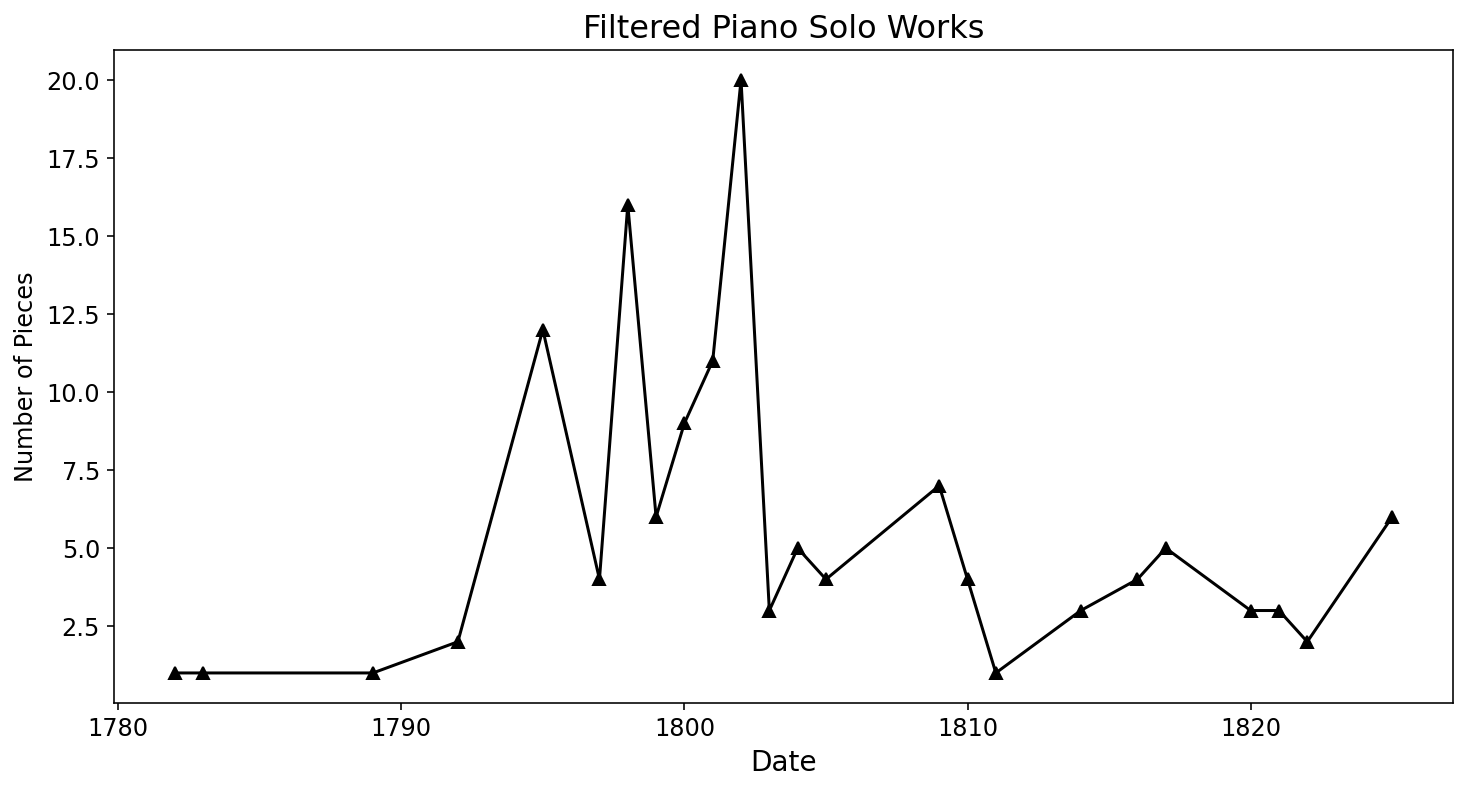

In [6]:
plt.figure(figsize=(12, 6))
grouped_piano = piano_df.groupby('Published').count()
plt.title('Filtered Piano Solo Works', size=16)
plt.xlabel('Date', size=14)
plt.ylabel('Number of Pieces', size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.plot(grouped_piano.index, grouped_piano['Title'], marker='^', color='k')

The figure above shows the number of works published by Beethoven each year. In the YCAC data set, each movement is regarded as a separate piece. 

After that, we merge the metadata with the specific slice data: 

In [7]:
### Load slices data. 
chord_df = pd.read_csv('./YCAC-data-1/BeethovenSlices.csv')
chord_df = chord_df.drop(columns=['Composer', 'LocalTonic', 'LocalMode', 'LocalSDForm_BassSD', 'Confidence'])
chord_df.head()

,offset,Chord,NormalForm,PCsInNormalForm,GlobalScaleDegrees,HighestPitch,LowestPitch,file
0,4.00,<music21.chord.Chord G4 E-4 C3>,"[0, 3, 7]","[0, 3, 7]","[0, 3, 7]",67,48,Sonata 26 ii Op 81a C min.mid
1,4.75,<music21.chord.Chord F#4 E-4 C3>,"[0, 3, 6]","[0, 3, 6]","[0, 3, 6]",66,48,Sonata 26 ii Op 81a C min.mid
2,5.00,<music21.chord.Chord A4 F#3 E-4 C3>,"[0, 3, 6, 9]","[0, 3, 6, 9]","[0, 3, 6, 9]",69,48,Sonata 26 ii Op 81a C min.mid
3,6.00,<music21.chord.Chord A4 A3 E-4 C3>,"[0, 3, 6]","[9, 0, 3]","[9, 0, 3]",69,48,Sonata 26 ii Op 81a C min.mid
4,7.00,<music21.chord.Chord A4 F#3 E-4 C3>,"[0, 3, 6, 9]","[0, 3, 6, 9]","[0, 3, 6, 9]",69,48,Sonata 26 ii Op 81a C min.mid


In [8]:
### Merge slice table and metadata table. 
desc_df = piano_df[['Filename', 'Published']]
pitch_df = pd.merge(desc_df, chord_df, left_on='Filename', right_on='file')
pitch_df = pitch_df.drop(columns=['file'])
pitch_df['LowestPitch(Hz)'] = pitch_df['LowestPitch'].apply(lambda x: music21.pitch.Pitch(x).freq440)
pitch_df['HighestPitch(Hz)'] = pitch_df['HighestPitch'].apply(lambda x: music21.pitch.Pitch(x).freq440)
pitch_df.head()

,Filename,Published,offset,Chord,NormalForm,PCsInNormalForm,GlobalScaleDegrees,HighestPitch,LowestPitch,LowestPitch(Hz),HighestPitch(Hz)
0,Variations WoO63 C minor.mid,1782,4.00,<music21.chord.Chord C5 E-3 G3 C3>,"[0, 3, 7]","[0, 3, 7]","[0, 3, 7]",72,48,130.812783,523.251131
1,Variations WoO63 C minor.mid,1782,4.75,<music21.chord.Chord C5>,[0],[0],[0],72,72,523.251131,523.251131
2,Variations WoO63 C minor.mid,1782,5.00,<music21.chord.Chord C5 E-3 G3 C3>,"[0, 3, 7]","[0, 3, 7]","[0, 3, 7]",72,48,130.812783,523.251131
3,Variations WoO63 C minor.mid,1782,5.50,<music21.chord.Chord C5>,[0],[0],[0],72,72,523.251131,523.251131
4,Variations WoO63 C minor.mid,1782,5.75,<music21.chord.Chord C5 E-3 G3 C3>,"[0, 3, 7]","[0, 3, 7]","[0, 3, 7]",72,48,130.812783,523.251131


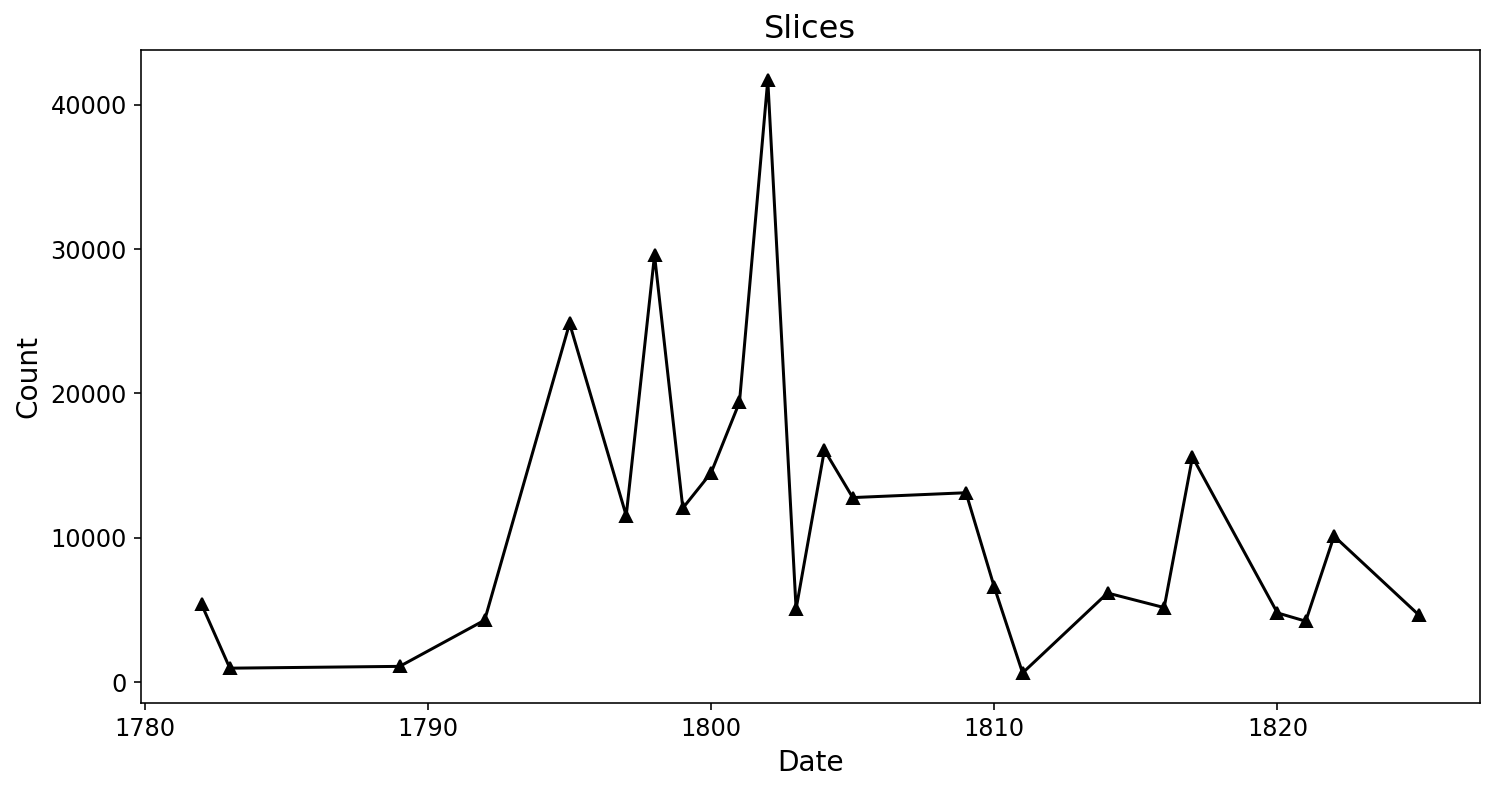

In [9]:
slices_df = pitch_df.groupby(['Published']).count()

plt.figure(figsize=(12, 6))
plt.title('Slices', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Date', size=14)
plt.ylabel('Count', size=14)
plt.plot(slices_df['Chord'], marker='^', color='k')

The figure above shows the number of slices published by Beethoven each year. It is worth noting that in 1783, 1789, and 1811, the numbers of slices are very small and less than 1100, so we delete them as outliers. Below is the relevant metadata:

In [10]:
piano_df[piano_df['Published'] == 1783]

,Title,Composer,CatNo,Date,Range,Inst1,Inst2,Inst3,Genre,Subgenre,Species,Species2,Nationality,Key,Modulation,Folder,Filename,Comments,Published
1,Rondo WoO49,Beethoven,WoO49,1783,NaN,piano,NaN,NaN,Rondo,NaN,NaN,NaN,Germany,A major,NaN,Beethoven,Rondo WoO49 A major.mid,NaN,1783


In [11]:
piano_df[piano_df['Published'] == 1789]

,Title,Composer,CatNo,Date,Range,Inst1,Inst2,Inst3,Genre,Subgenre,Species,Species2,Nationality,Key,Modulation,Folder,Filename,Comments,Published
2,Preludes through All Keys Op. 39 No. 1,Beethoven,Op39no1,1789,NaN,piano,NaN,NaN,Prelude,NaN,NaN,NaN,Germany,C major,NaN,Beethoven,Preludes Op 39 1 C major.mid,NaN,1789


In [12]:
piano_df[piano_df['Published'] == 1811]

,Title,Composer,CatNo,Date,Range,Inst1,Inst2,Inst3,Genre,Subgenre,Species,Species2,Nationality,Key,Modulation,Folder,Filename,Comments,Published
106,Turkish march from Op 113 (Arrangement),Beethoven,Op113,1811,NaN,Piano,NaN,NaN,NaN,NaN,NaN,NaN,Germany,Bb major,NaN,Beethoven,Turkish March from Op 113 Bb major.mid,Arrangement for Piano,1811


In [13]:
piano_df = piano_df[(piano_df['Published'] != 1783) & (piano_df['Published'] != 1789) & (piano_df['Published'] != 1811)]
pitch_df = pitch_df[(pitch_df['Published'] != 1783) & (pitch_df['Published'] != 1789) & (pitch_df['Published'] != 1811)]

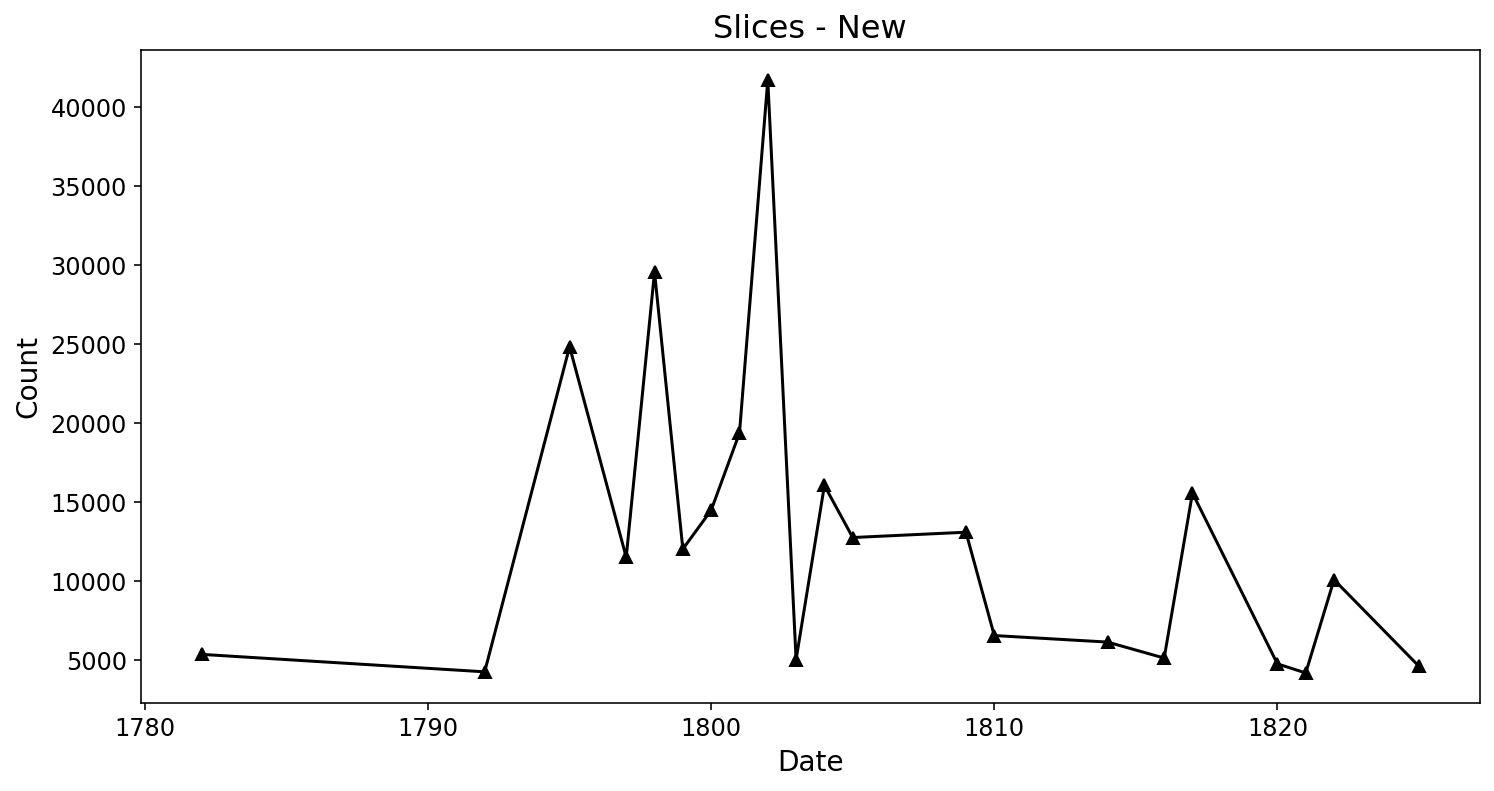

In [14]:
slices_df = pitch_df.groupby(['Published']).count()

plt.figure(figsize=(12, 6))
plt.title('Slices - New', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Date', size=14)
plt.ylabel('Count', size=14)
plt.plot(slices_df['Chord'], marker='^', color='k')

### Analysis on pitches

YCAC provides the highest pitch and lowest pitch of each slice. The followings are some of their statistical characteristics.

In [15]:
pitch_df['HighestPitch'].describe()

count    267512.000000
mean         71.143556
std          11.364808
min          27.000000
25%          65.000000
50%          72.000000
75%          79.000000
max         101.000000
Name: HighestPitch, dtype: float64

In [16]:
pitch_df['LowestPitch'].describe()

count    267512.000000
mean         53.445759
std          12.730104
min          23.000000
25%          44.000000
50%          52.000000
75%          61.000000
max         100.000000
Name: LowestPitch, dtype: float64

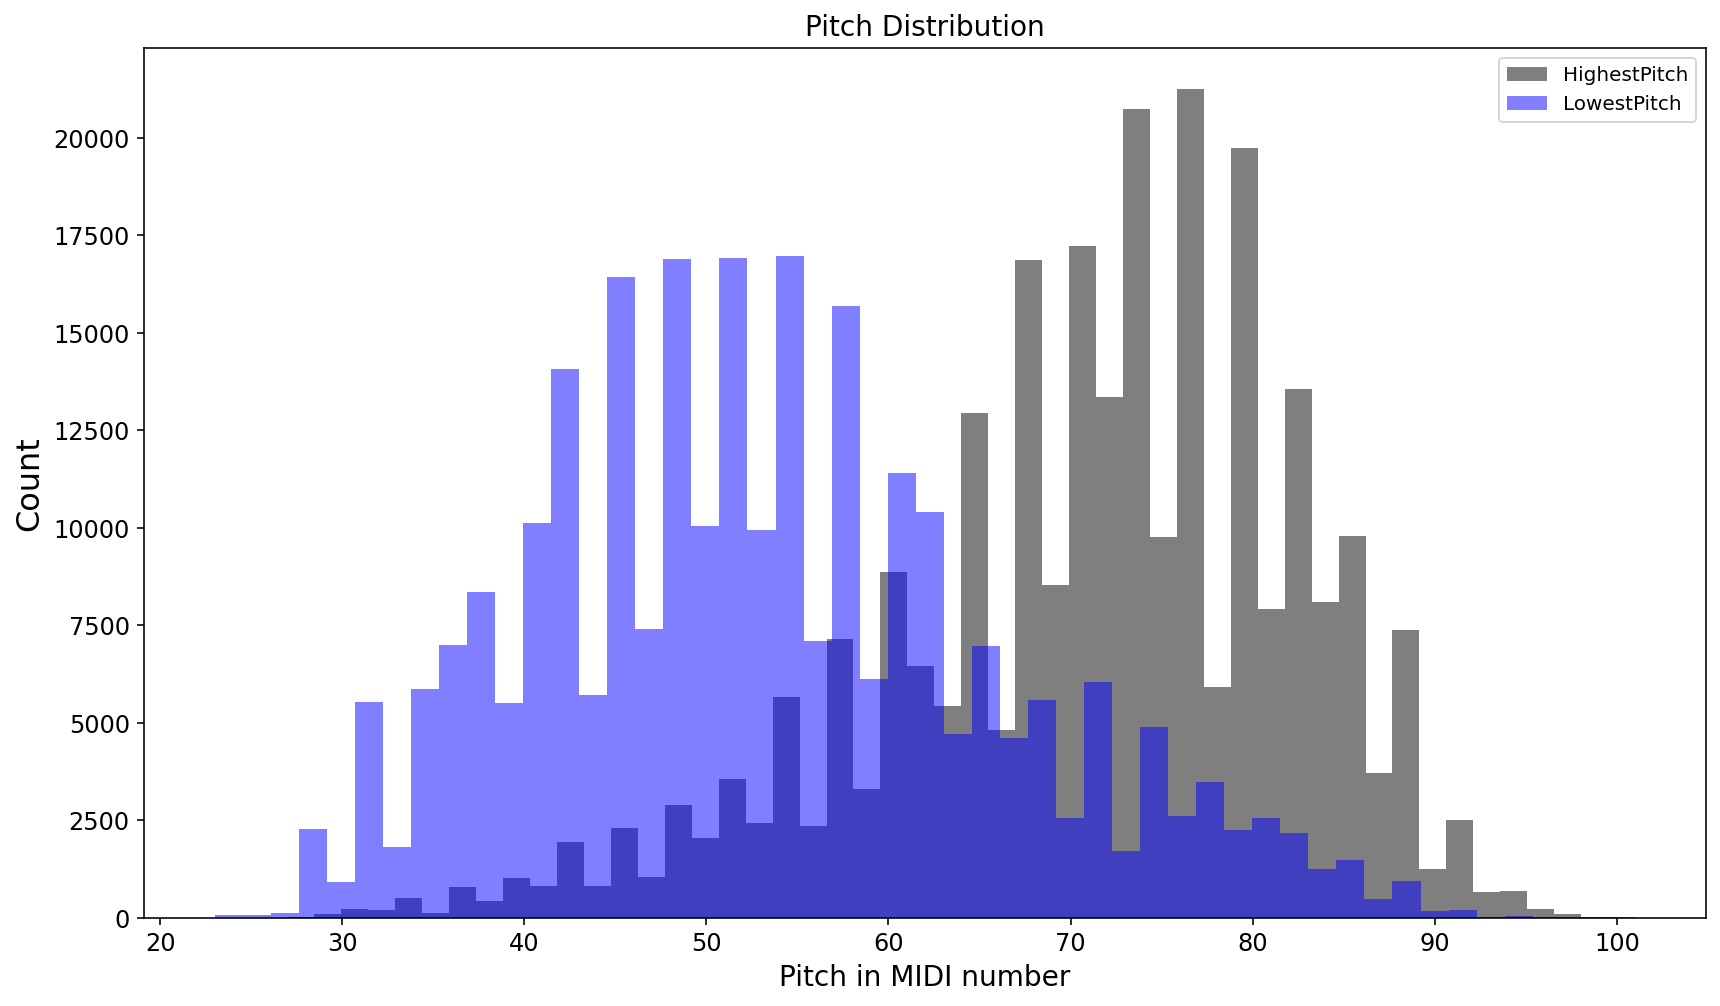

In [17]:
plt.figure(figsize=(14, 8))
plt.title('Pitch Distribution', size=14)
plt.xlabel('Pitch in MIDI number', size=14)
plt.ylabel('Count', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.hist(pitch_df['HighestPitch'], bins=50, color='black', alpha=0.5, label='HighestPitch')
plt.hist(pitch_df['LowestPitch'], bins=50, color='blue', alpha=0.5, label='LowestPitch')
plt.legend()

As can be seen from the above figure, the distribution of the lowest pitches is right-skewed; the distribution of the highest pitches is left-skewed, and the peak is higher than the lowest pitches. Considering that there are a large number of slices with only one tone, such a distribution is reasonable. 

In [18]:
### Calculate differences (pitch fluctuations) between neighboring slices for both lowest pitches and highest pitches.
fluc_df = pd.DataFrame()

for _, row in piano_df[['Filename', 'Published']].iterrows():
    piece_df = pitch_df[pitch_df['Filename'] == row['Filename']]
    
    piece_df['LowestPitch(Hz)_lag1'] = piece_df['LowestPitch(Hz)'].shift(1)
    piece_df['HighestPitch(Hz)_lag1'] = piece_df['LowestPitch(Hz)'].shift(1)
    piece_df = piece_df.dropna()
    piece_df['Fluctuation_low'] = piece_df['LowestPitch(Hz)'] - piece_df['LowestPitch(Hz)_lag1']
    piece_df['Fluctuation_high'] = piece_df['HighestPitch(Hz)'] - piece_df['HighestPitch(Hz)_lag1']
    
    fluc_df = pd.concat([fluc_df, piece_df])

In [19]:
### Demonstrate distribution for average frequencies in different years.
convert_chord = lambda x: x.split(' ', 1)[1][:-1].split(' ')

avg_freq = []
year_list = fluc_df['Published'].unique()
for year in year_list:
    freq_count = 0
    freq_sum = 0
    window_df = fluc_df[fluc_df['Published'] == year]
    for chord in window_df['Chord']:
        for pitch in convert_chord(chord):
            freq_sum += music21.pitch.Pitch(pitch).freq440
            freq_count += 1
    avg_freq.append(freq_sum / freq_count)

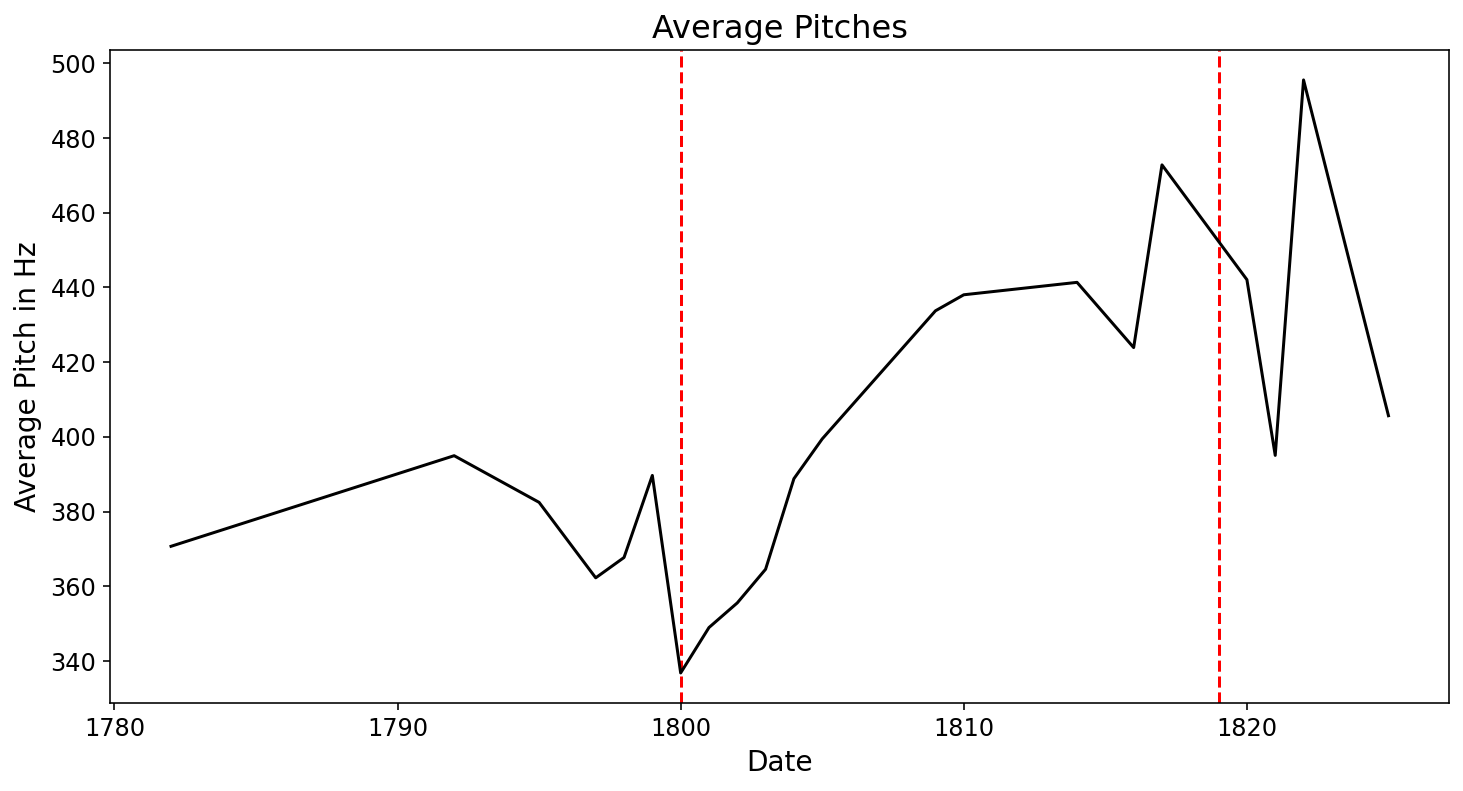

In [20]:
plt.figure(figsize=(12, 6))
plt.axvline(1800, color='red', ls='--')
plt.axvline(1819, color='red', ls='--')
plt.title('Average Pitches', size=16)
plt.xlabel('Date', size=14)
plt.ylabel('Average Pitch in Hz', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.plot(year_list, avg_freq, color='k')

The figure above shows the change in the average frequency of works each year. The peak appears in the second period, and the second period shows an overall upward trend. The first period and the third period do not display uniform characteristics, and both fluctuate significantly. 

Text(0.5, 0, 'Date')

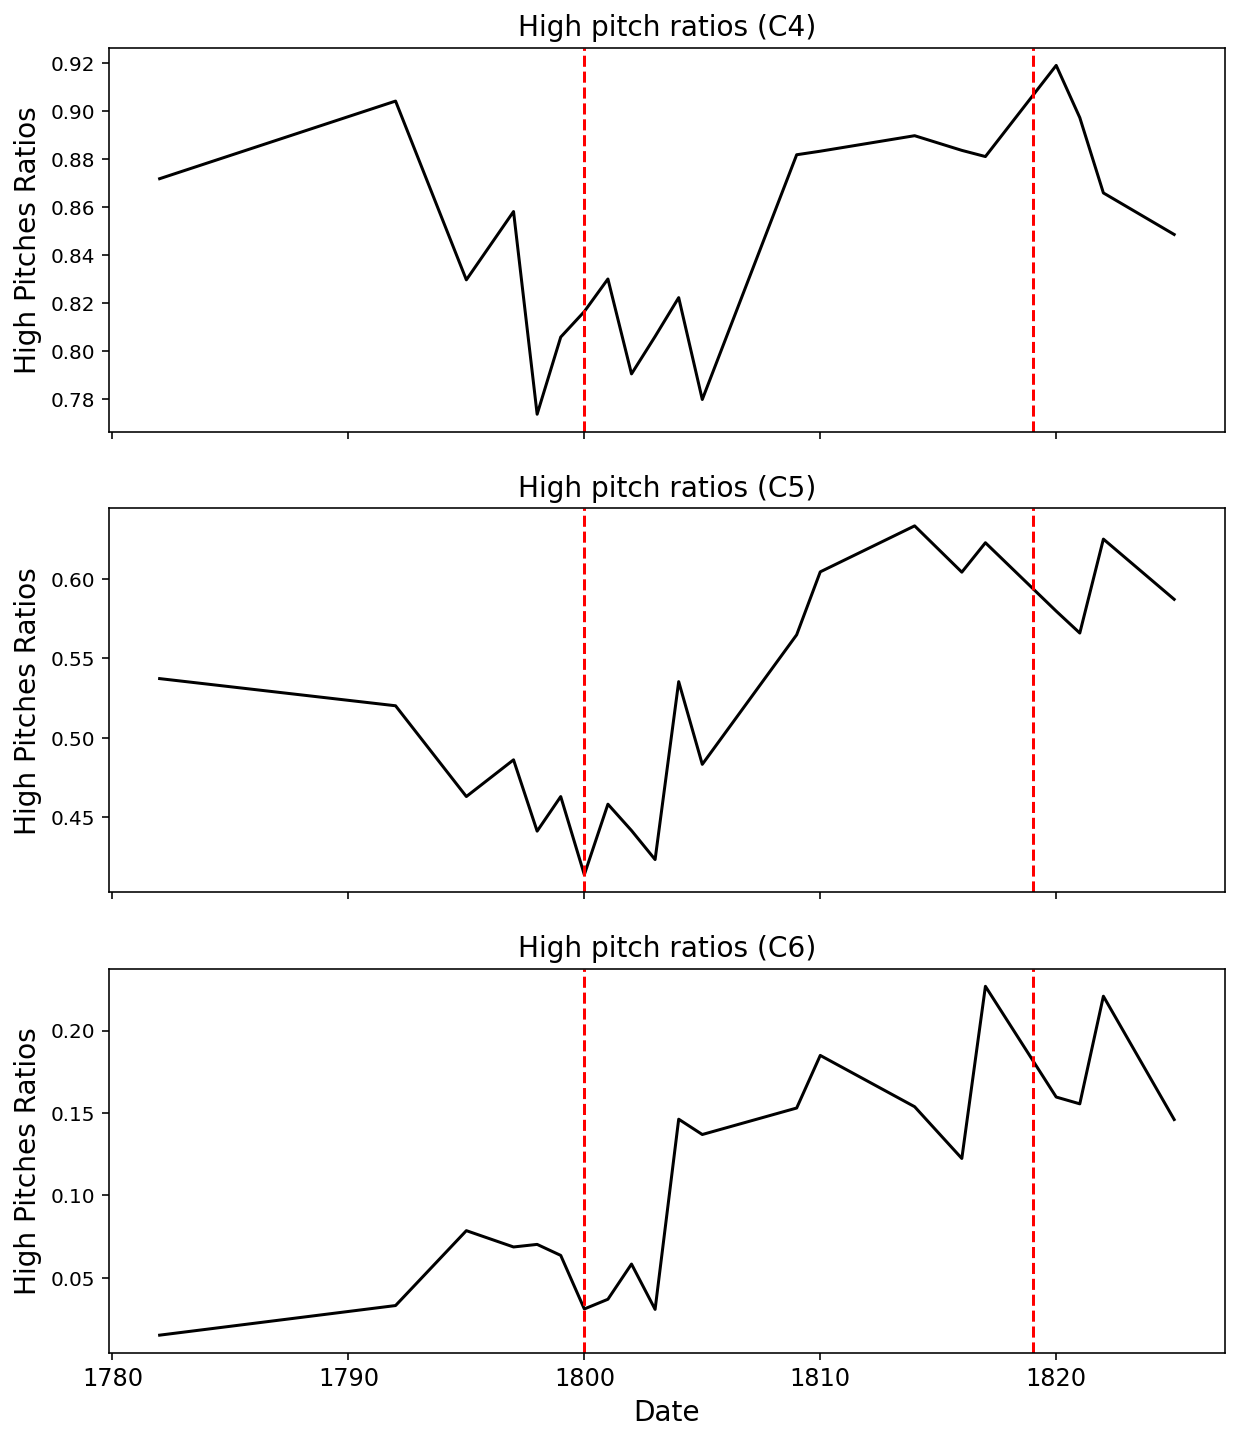

In [21]:
### "High Pitches" ratios based on 3 thresholds: C4, C5, C6.

pitch_cat = 'HighestPitch'
base_count = fluc_df.groupby(['Published']).count()[pitch_cat]

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
thresholds = [60, 72, 84]
thresholds_key = ['C4', 'C5', 'C6']
for i in [0, 1, 2]:
#     thres_count = fluc_df[fluc_df[pitch_cat] > i].groupby(['Published']).count()[pitch_cat]
#     plt.plot(thres_count / base_count, label=f'{music21.pitch.Pitch(i)}')
    thres_count = fluc_df[fluc_df[pitch_cat] > thresholds[i]].groupby(['Published']).count()[pitch_cat]
    
    axs[i].plot(thres_count / base_count, label=f'{music21.pitch.Pitch(i)}', color='k')
    axs[i].set_ylabel('High Pitches Ratios', size=14)
    axs[i].axvline(1800, color='red', ls='--')
    axs[i].axvline(1819, color='red', ls='--')
    axs[i].set_title(f'High pitch ratios ({thresholds_key[i]})', size=14)

plt.xticks(size=12)
plt.xlabel('Date', size=14)

The above figure shows the ratio of notes with frequencies higher than C4, C5, and C6. 

In the first period, the three pictures are of different shapes and have their own characteristics. But the three graphs all show an overall upward trend in the second period.

After the peaks of C5 and C6, Beethoven's ear disease intensified and caused deafness in 181. No major fluctuations appear in both curves, and the levels are comparable to the second periods.

Then we calculate the fluctuations of the highest pitches and the lowest pitches in adjacent slices in each piece of music (Liu et al., 2013). 

$$
Z_f(t) = f(t+1) - f(t), t=1,2,3, ... ,N-1.
$$

In the above formula, $f(·)$ is the highest frequency or the lowest frequency of a single slice, and $t$ represents time. 

After calculating the fluctuations, we draw the CCDF curves on a log scale. But because these curves do not satisfy the power-law, we have to use the following formula to fit the CCDF curves: 

$$
F(x) = ae^{-bx} + c
$$

$a$, $b$, and $c$ are all unknowns to be solved.

In [22]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

def get_R_squared(xdata, ydata, f, *popt):
    '''
    Return R^2 of the fitted model.
    '''
    residuals = ydata- f(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def get_coeff(data, cat='low'):
    '''
    Return sampled points and coefficients of the fitted model for CCDF. 
    '''
    ax = plt.gca()
    if cat == 'low':
        ax = sns.ecdfplot(data, x='Fluctuation_low', complementary=True, log_scale=(True, True))
    else:
        ax = sns.ecdfplot(data, x='Fluctuation_high', complementary=True, log_scale=(True, True))
    xdata, ydata = ax.lines[-1].get_data()
    popt, pcov = curve_fit(func, xdata[1:], ydata[1:], maxfev=5000)
    r_squared = get_R_squared(xdata[1:], ydata[1:], func, *popt)
    return r_squared, popt

To better reflect the aggregation effect of pitch fluctuations on CCDF, we use a sliding window method to calculate the coefficients to be fitted one by one. The size of the sliding window gradually expands from 1 to Beethoven's career span. 

In [23]:
pos_low_exp = []
neg_low_exp = []
pos_high_exp = []
neg_high_exp = []
year_list = piano_df['Published'].unique()

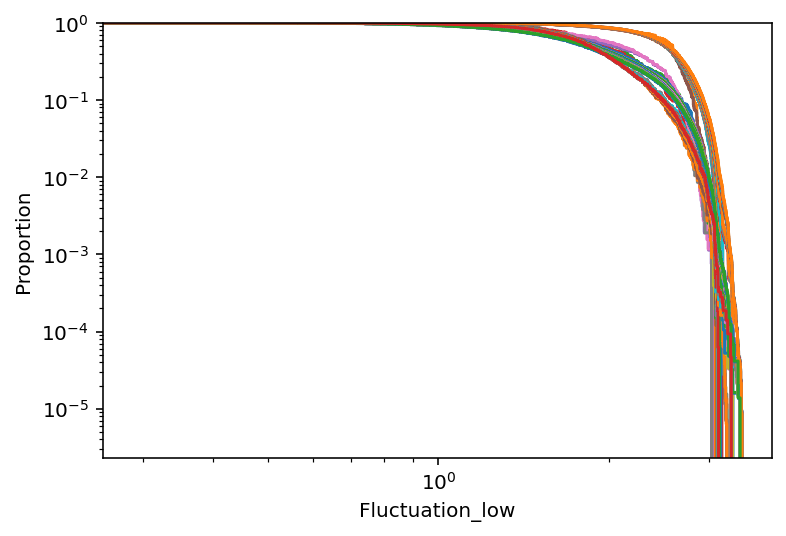

In [24]:
### Calculate coefficients of the fitted models using sliding windows. 
for i in range(1, len(year_list)+1):
    window = year_list[:i]
    window_df = fluc_df[fluc_df['Published'].isin(window)]
    
    # Model for lowest pitch fluctuations (in positive direction). 
    data = window_df[window_df['Fluctuation_low'] > 0]
    _, popt = get_coeff(data, 'low')
    pos_low_exp.append(popt)
    
    # Model for highest pitch fluctuations (in positive direction). 
    data = window_df[window_df['Fluctuation_high'] > 0]
    _, popt = get_coeff(data, 'high')
    pos_high_exp.append(popt)
    
    # Model for lowest pitch fluctuations (in positive direction). 
    data = window_df[window_df['Fluctuation_low'] < 0]
    data['Fluctuation_low'] = -data['Fluctuation_low']
    _, popt = get_coeff(data, 'low')
    neg_low_exp.append(popt)
    
    # Model for highest pitch fluctuations (in positive direction). 
    data = window_df[window_df['Fluctuation_high'] < 0]
    data['Fluctuation_high'] = -data['Fluctuation_high']
    _, popt = get_coeff(data, 'high')
    neg_high_exp.append(popt)

The above 4 figures reflect the trends of coeff b for the 4 categories separately.

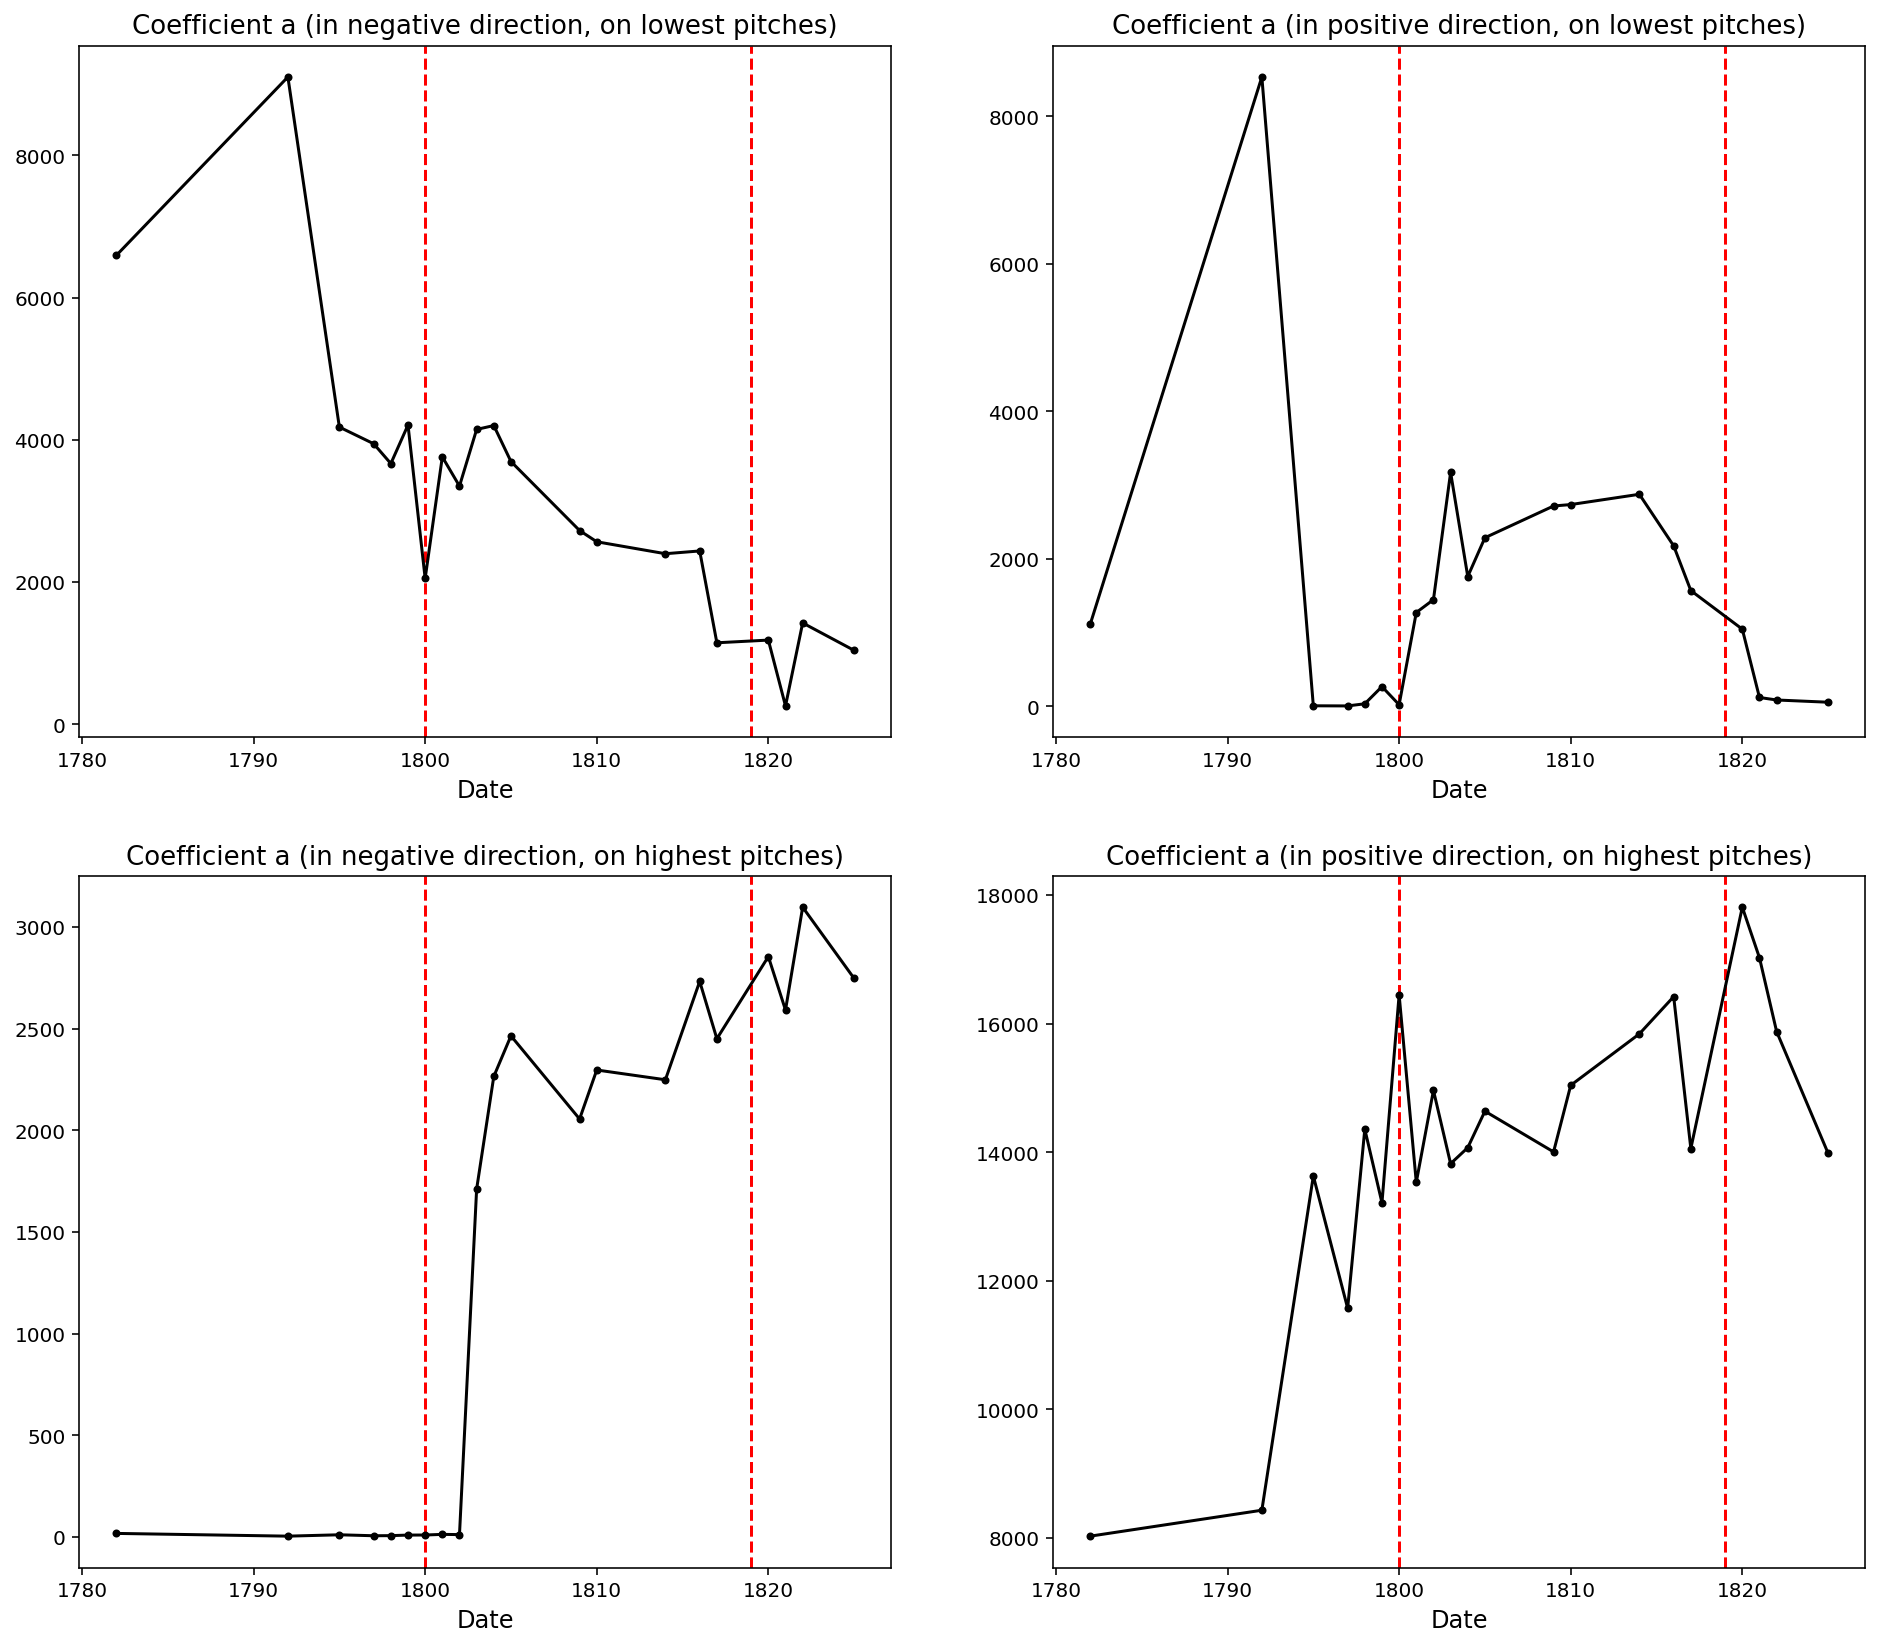

In [25]:
def draw_coeff(i, j, coeff, cat, title):
    axs[i, j].axvline(1800, color='red', ls='--')
    axs[i, j].axvline(1819, color='red', ls='--')
    axs[i, j].set_xlabel('Date', size=12)
    if coeff == 0:
        axs[i, j].set_title(f'Coefficient a ({title})', size=13)
    elif coeff == 1:
        axs[i, j].set_title(f'Coefficient b ({title})', size=13)
    else:
        axs[i, j].set_title(f'Coefficient c ({title})', size=13)
    axs[i, j].plot(year_list, list(factor[coeff] for factor in cat), marker='.', color='k')

fig, axs = plt.subplots(2, 2, figsize=(16, 14))
draw_coeff(0, 0, 0, neg_low_exp, 'in negative direction, on lowest pitches')
draw_coeff(0, 1, 0, pos_low_exp, 'in positive direction, on lowest pitches')
draw_coeff(1, 0, 0, neg_high_exp, 'in negative direction, on highest pitches')
draw_coeff(1, 1, 0, pos_high_exp, 'in positive direction, on highest pitches')

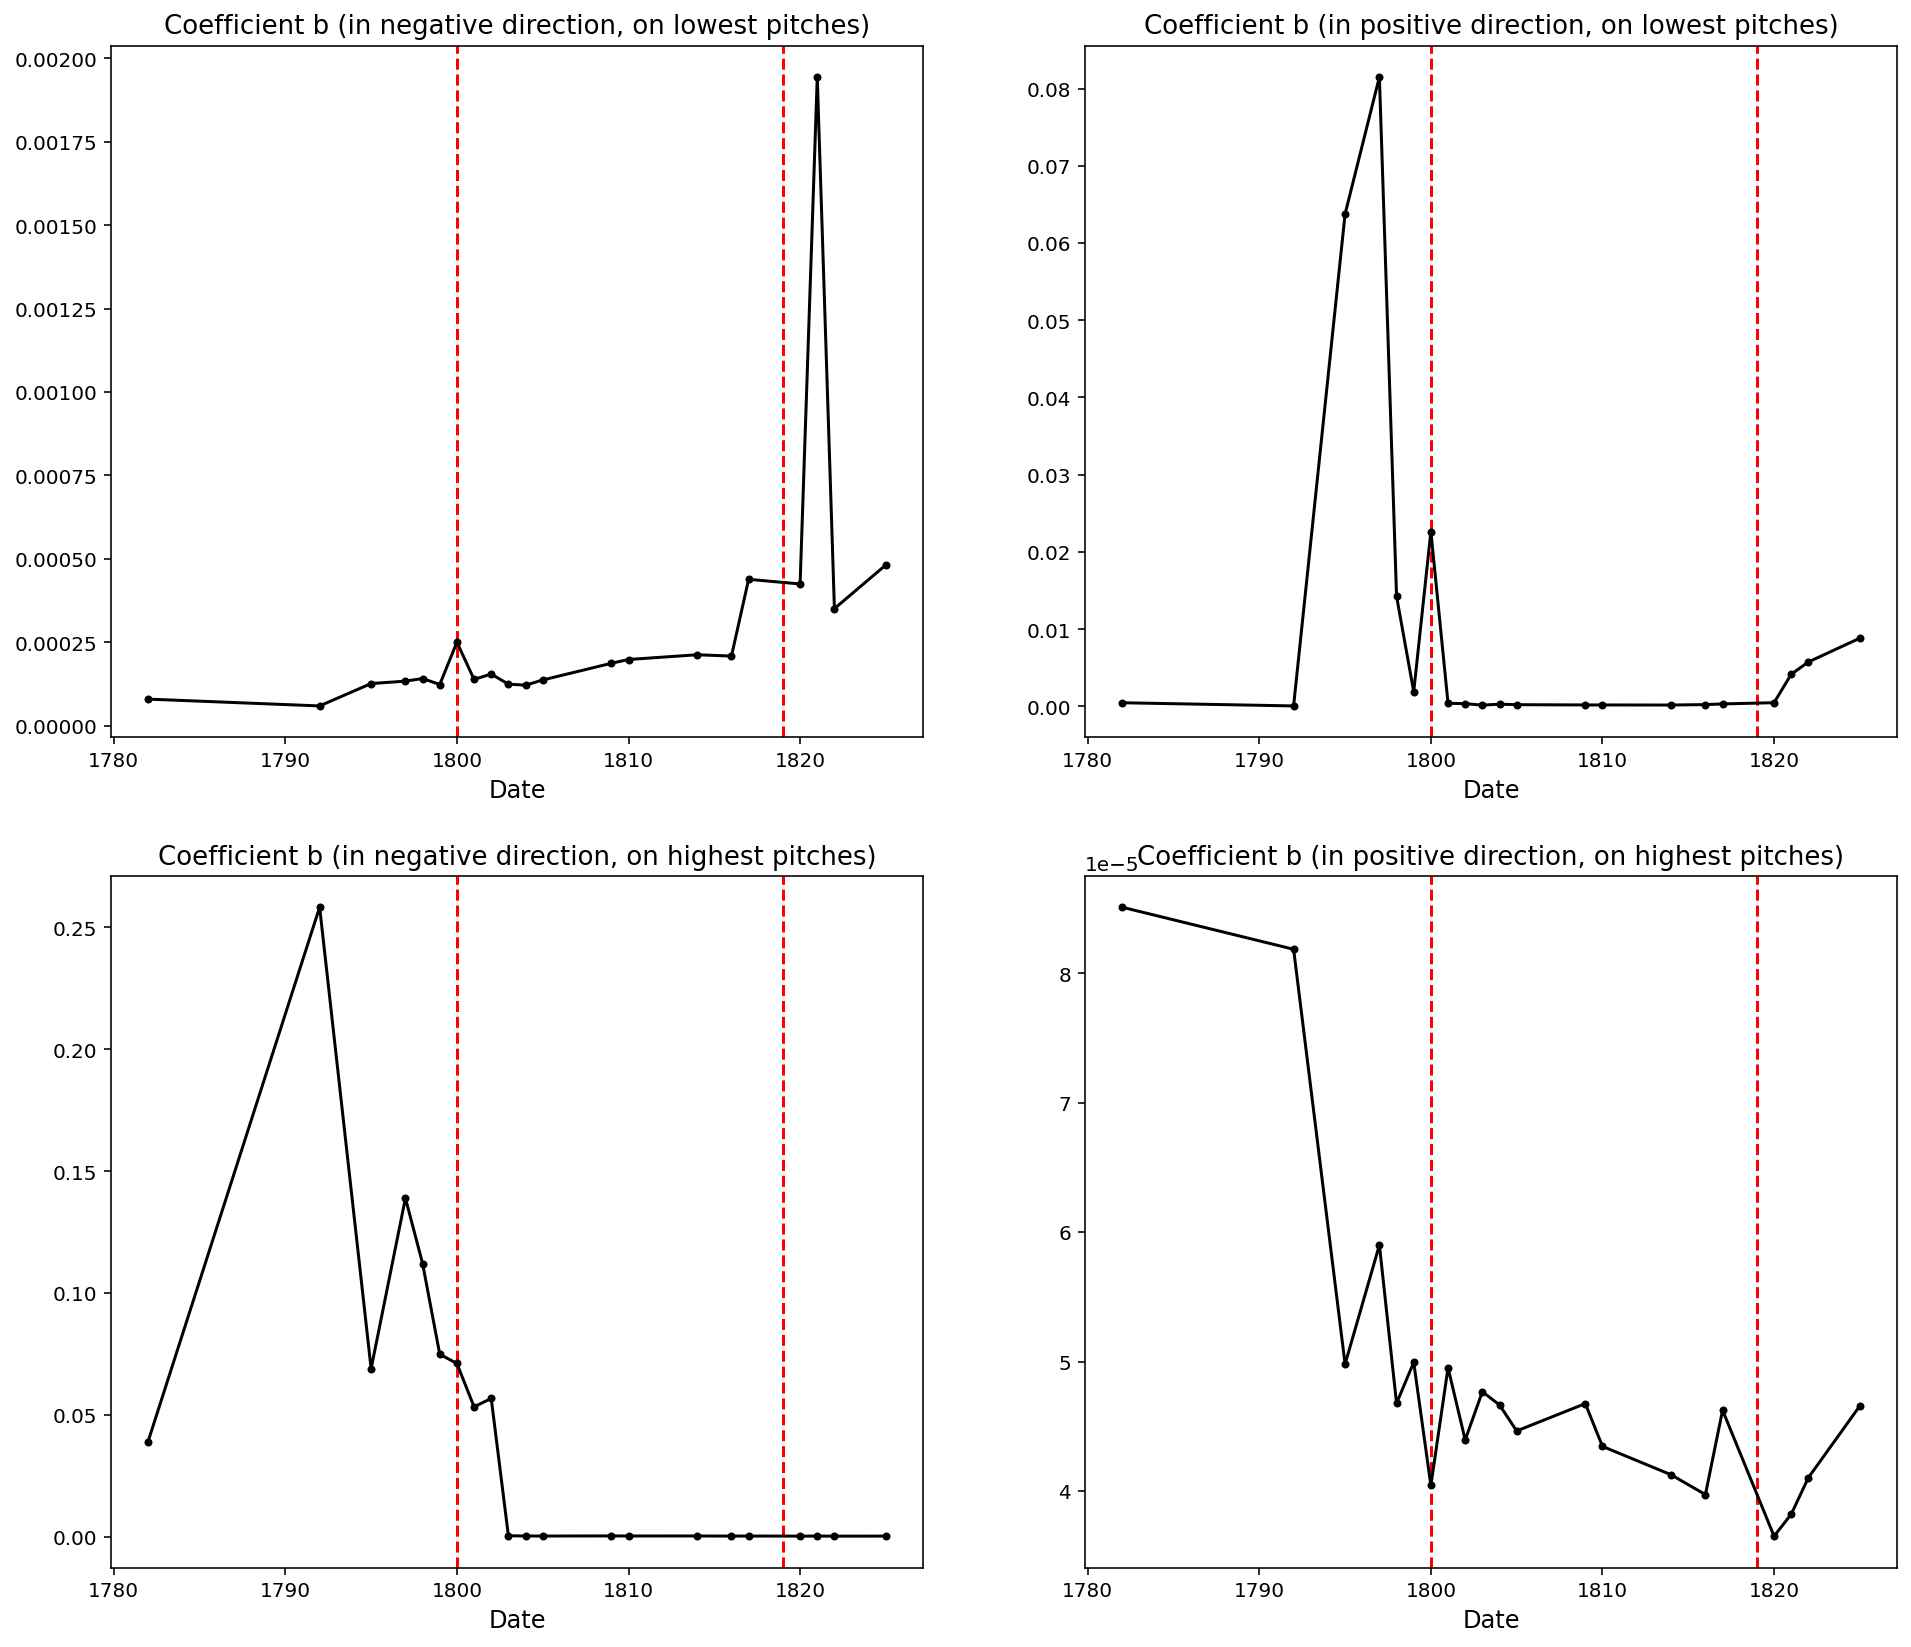

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
draw_coeff(0, 0, 1, neg_low_exp, 'in negative direction, on lowest pitches')
draw_coeff(0, 1, 1, pos_low_exp, 'in positive direction, on lowest pitches')
draw_coeff(1, 0, 1, neg_high_exp, 'in negative direction, on highest pitches')
draw_coeff(1, 1, 1, pos_high_exp, 'in positive direction, on highest pitches')

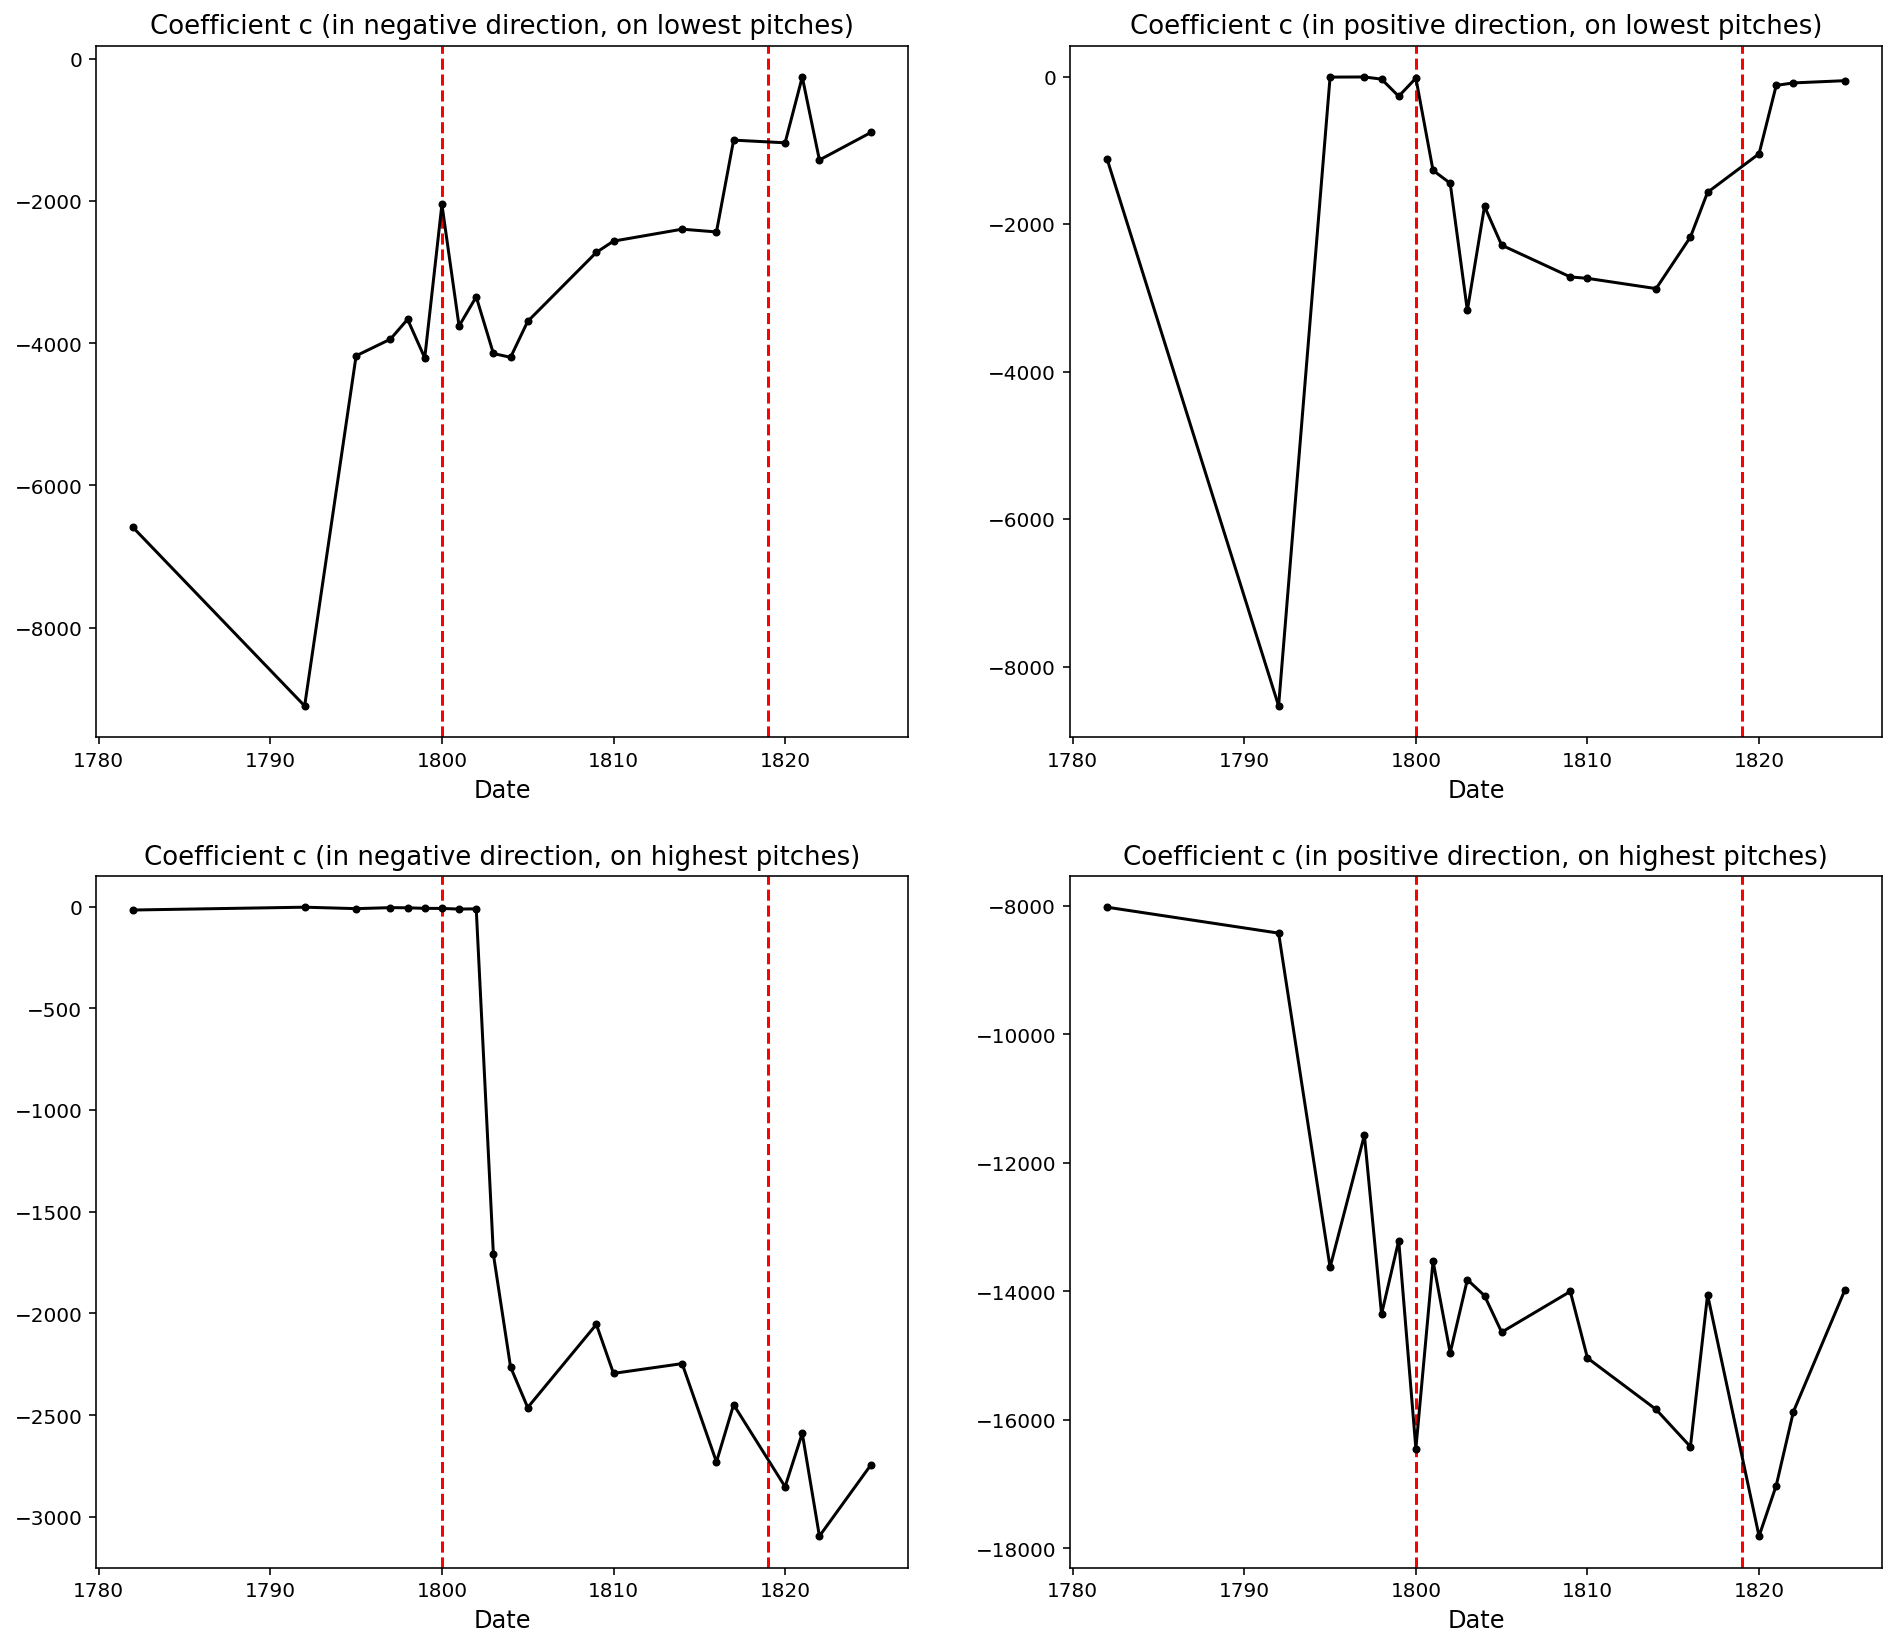

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
draw_coeff(0, 0, 2, neg_low_exp, 'in negative direction, on lowest pitches')
draw_coeff(0, 1, 2, pos_low_exp, 'in positive direction, on lowest pitches')
draw_coeff(1, 0, 2, neg_high_exp, 'in negative direction, on highest pitches')
draw_coeff(1, 1, 2, pos_high_exp, 'in positive direction, on highest pitches')

The CCDF curve does not satisfy power-law, and their shapes are affected by three coefficients at the same time. But to better understand the frequency fluctuations used by Beethoven, we have drawn the trends of some coefficients. 

What is surprising is that the above pictures all show obvious boundary effects, which means that Beethoven’s creative habits during these periods have not only changed the usage of tones, and also affected the rules of tone conversion. In addition, the three periods are based on the progress of ear disease, so the above pictures more powerfully testifies that Beethoven’s ear disease has affected his creative habits. More specific discussions will be launched in the next assignment. 

### Analysis on chords

With the support of ratios of high-frequency tones and CCDF, we can be sure that ear diseases have a certain influence on Beethoven's composition style. Next, we will explore the role of ear disease on chords and discuss whether it can strengthen or weaken our current conclusions. It is worth mentioning that the chords in the following all refer to slices containing multiple notes in  YCAC. 

#### New chords

We first count the use of new chords in each year's works. The "new chords" here refer to chords that have never been used in previous works.

We select the other five musicians (Chopin, Mozart, Schumann, Schubert, and Liszt) with the most piano solo works in the YCAC dataset, and then removed the two musicians (Schumann and Schubert) with extremely long publishing intervals. At last, we remove the years that have less than 1100 slices for the remaining three musicians. 

In [28]:
other_composers = ['Bach', 'Beethoven', 'Brahms', 'Byrd', 'Chopin', 'Debussy',
                   'Handel', 'Haydn', 'Liszt', 'Mendelssohn',
                   'Mozart', 'Saint-Saens', 'Scarlatti',
                   'Schubert', 'Schumann', 'Tchaikovsky', 
                   'Telemann', 'Vivaldi', 'Wagner']
other_composers_lower = [i.lower() for i in other_composers]

In [29]:
### Reuse code in previous cells.
composer_df = pd.read_csv('./YCAC-data-1/YCAC-metadata.csv', lineterminator='\r')
composer_df = composer_df[composer_df['Composer'].str.lower().isin(other_composers_lower)]
composer = composer_df.reset_index(drop=True)
composer = composer[composer['Inst1'].str.lower() == 'piano']
composer = composer[composer['Inst2'].isnull()]
composer['Published'] = composer.apply(filter_published_date, axis=1)
composer = composer[composer['Published'] > 0]

composer = composer[composer['Filename'].notnull()]
composer['Filename'] = composer['Filename'].apply(lambda x: x + '.mid')

composer = composer.sort_values(by=['Published'], ascending=True)
composer.reset_index(drop=True, inplace=True)
composer = composer[['Filename', 'Published', 'Composer', 'Title']]

other_composers = ['Beethoven', 'Chopin', 'Mozart', 'Liszt'] # ,'Schubert', 'Schumann']

composer.groupby('Composer').count().sort_values(by='Title', ascending=False).head(6)

,Filename,Published,Title
Composer,,,
Chopin,224,224,224
Mozart,178,178,178
Schumann,136,136,136
Beethoven,133,133,133
Schubert,132,132,132
Liszt,103,103,103


In [30]:
def plot_composer_cdf(name, i, j):
    from statistics import median
    
    bach_df = pd.read_csv(f'./YCAC-data-1/{name}Slices.csv')
    bach_df = bach_df.drop(columns=['Composer', 'LocalTonic', 'LocalMode', 'LocalSDForm_BassSD', 'Confidence'])

    bach_df = pd.merge(composer, bach_df, left_on='Filename', right_on='file') 

    slices_counts = bach_df.groupby('Published').count()['Chord'] 
    ilegal_years = [i for i in slices_counts.index if slices_counts[i] < 1100]
    bach_df = bach_df[bach_df.apply(lambda x: x['Published'] not in ilegal_years, axis=1)]
    
    ### Calculate new chords by years.
    chord_types = []
    all_chords = set()
    year_list = list(bach_df['Published'].unique())
    for year in year_list:
        new_chords = set()
        window_df = bach_df[bach_df['Published'] == year]
        for chord in window_df['Chord']:
            element = convert_chord(chord)
            if len(element) > 1:
                new_chords.add(frozenset(element))
        chord_types.append(new_chords - all_chords)
        all_chords = all_chords.union(new_chords)
   
    new_chord = list(len(i) for i in chord_types)  
    total_chord = bach_df.groupby(['Published']).count()
    total_slices = list(total_chord['Chord'])
    new_ratios = list(new_chord[i] / total_slices[i] for i in range(len(new_chord)))

    axs[i, j].plot(year_list, new_ratios, marker='.', color='k')
    axs[i, j].set_title(f'Ratios of new chords - {name}', size=14)
    axs[i, j].set_xlabel('Date', size=12)

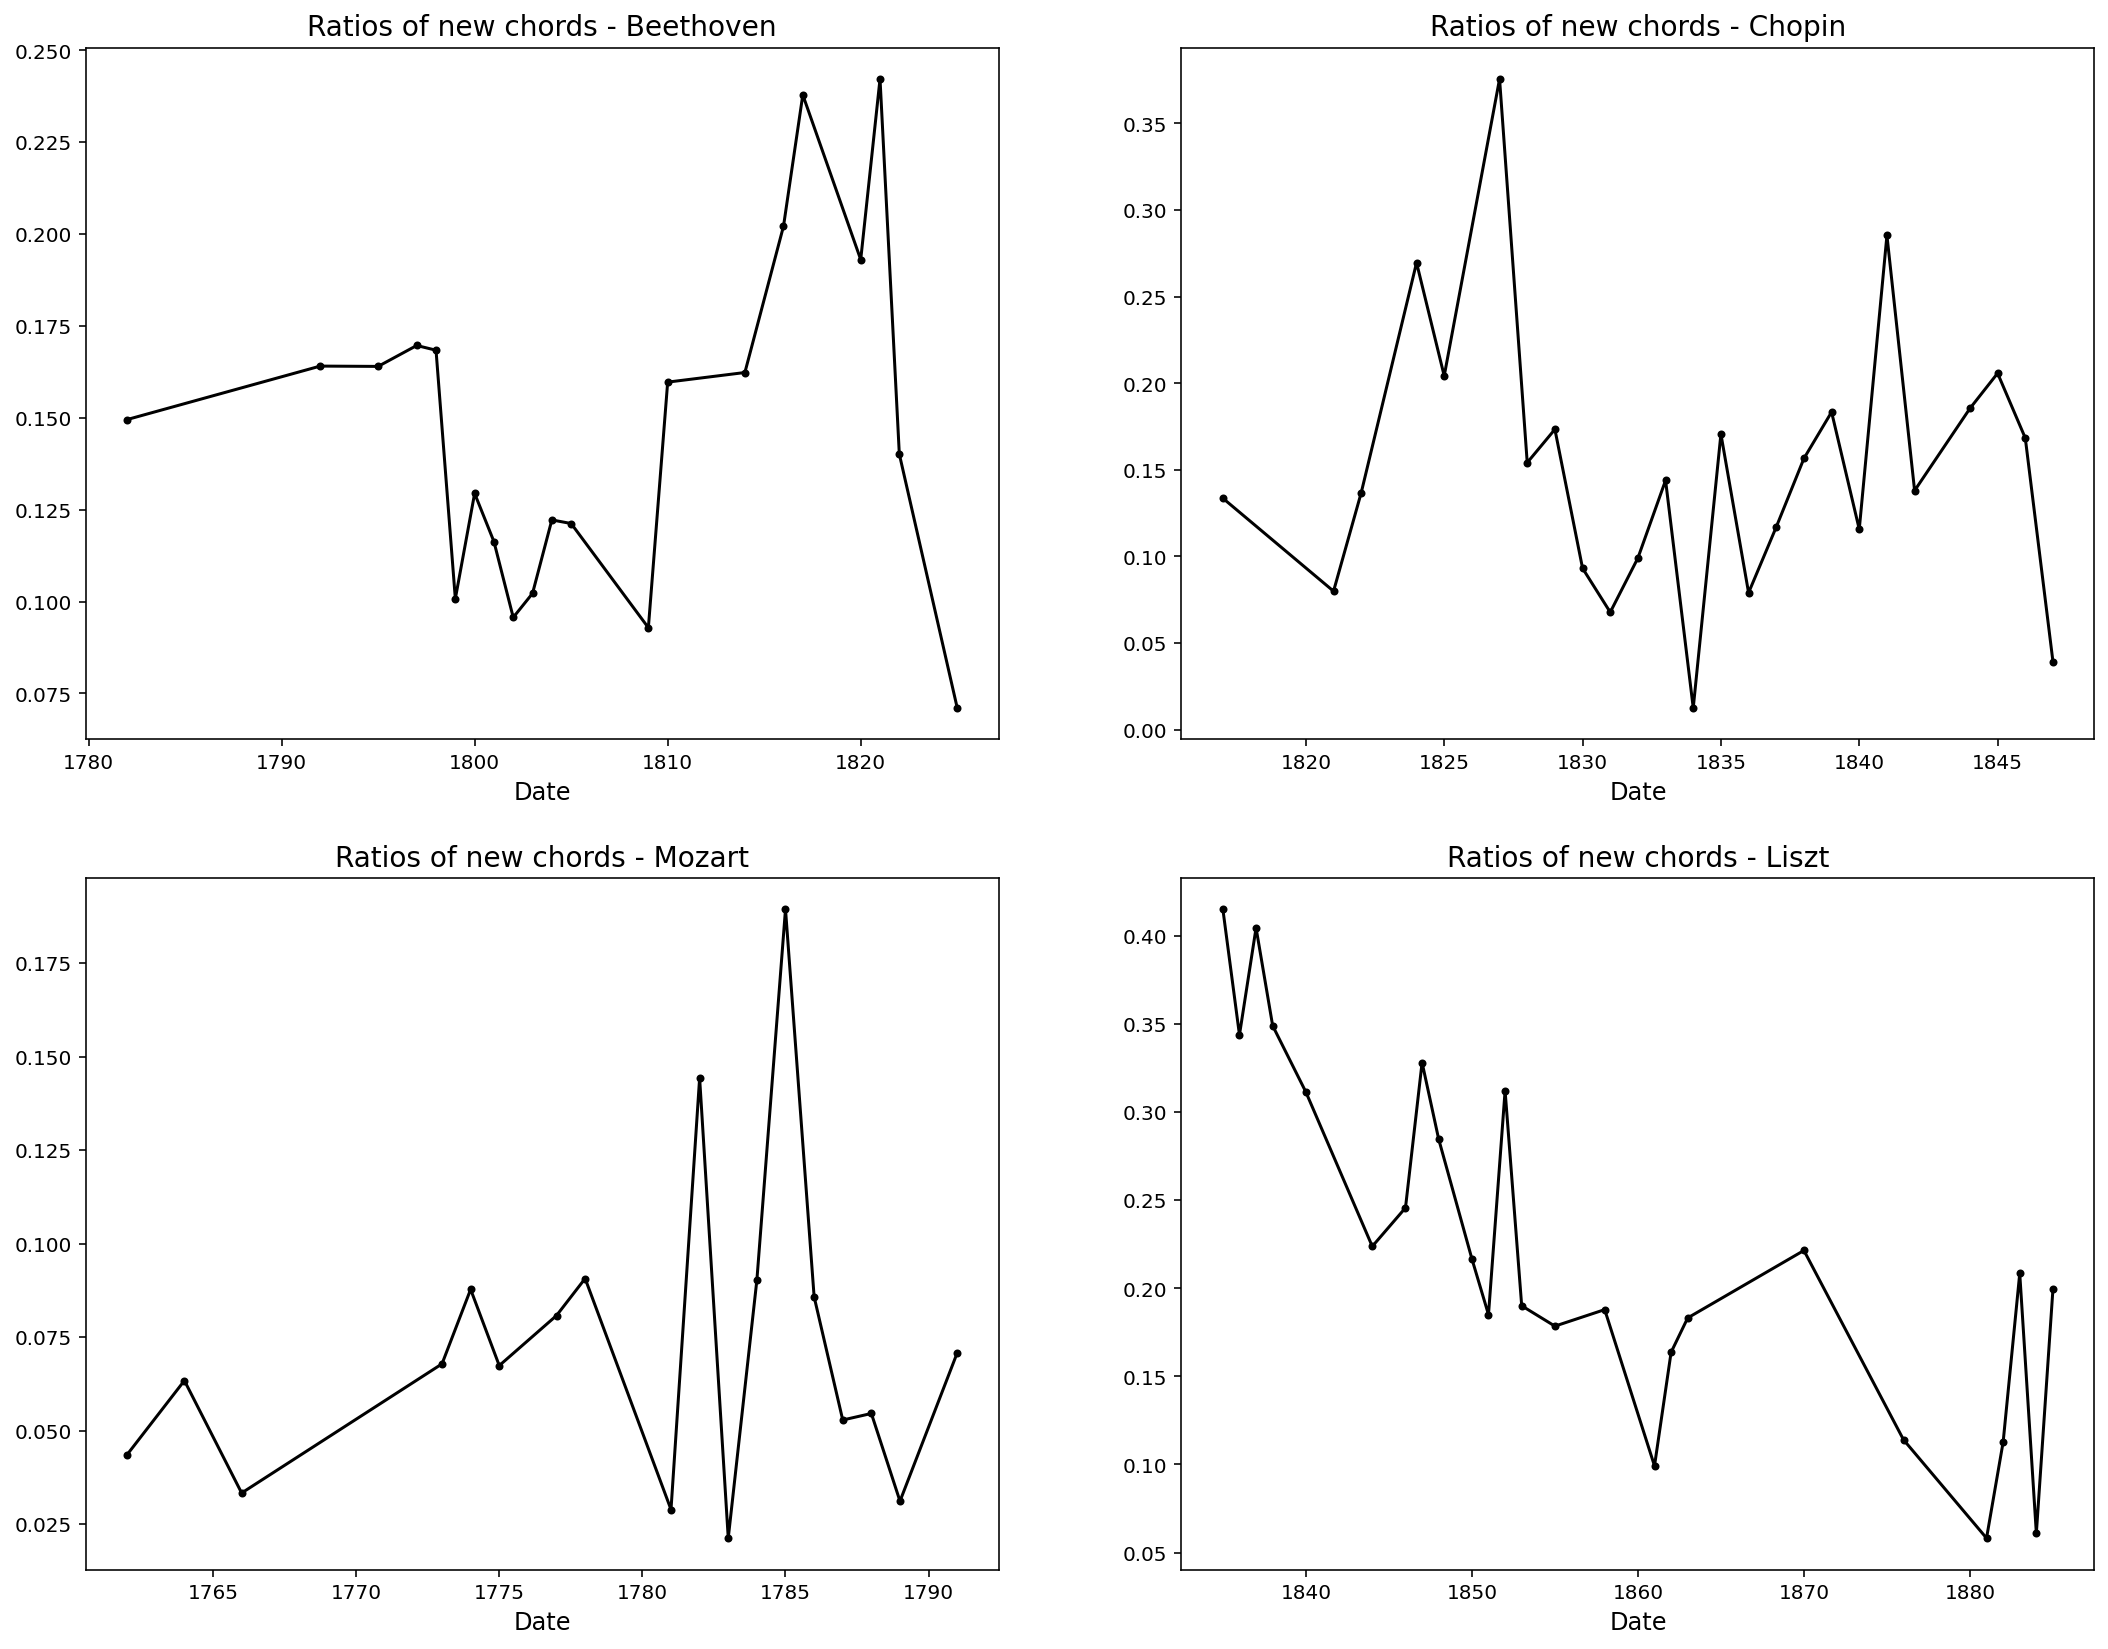

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_composer_cdf('Beethoven', 0, 0)
plot_composer_cdf('Chopin', 0, 1)
plot_composer_cdf('Mozart', 1, 0)
plot_composer_cdf('Liszt', 1, 1)

Based on the previous hypothesis, we infer that as Beethoven’s ear disease worsened, he would try to use more new chords. Therefore, we also assume that for other composers with normal hearing, their curves will gradually decrease and show a downward trend due to more and more chords that they had used. 

However, in the result graphs, the trend characteristics of each composer are different. Actually. Only the curve of Liszt shows an overall downward trend, while the curves of Chopin, Mozart, and Beethoven's did not, and these three composers all showed an upward trend in the mid-term of their career life. Because Beethoven's curve does not show unique characteristics, the proportions of the new chords are not enough to reflect the effects of deafness. So we need to reject the original hypothesis.

#### Consonance and dissonance

Next, we analyze the proportion of consonances in each year's works using the `isConsonant()` method in music21. 

The document for `isConsonant()` can be found in http://web.mit.edu/music21/doc/moduleReference/moduleChord.html:
> returns True if the chord is
>
> + one pitch two pitches: uses isConsonant() , which checks if interval is a major or minor third or sixth or perfect fifth. 
> + three pitches: if chord is a major or > minor triad not in second inversion.
>
>
> These rules define all common-practice consonances (and earlier back to about 1300 all imperfect consonances)

Similarly, we also draw the proportions of the four composers using consonance in their works each year. The pictures are below.

In [34]:
### Reuse code in previous cells.
def plot_consonance_ratios(name):
    bach_df = pd.read_csv(f'./YCAC-data-1/{name}Slices.csv')
    bach_df = bach_df.drop(columns=['Composer', 'LocalTonic', 'LocalMode', 'LocalSDForm_BassSD', 'Confidence'])
    bach_df = pd.merge(composer, bach_df, left_on='Filename', right_on='file') 
    slices_counts = bach_df.groupby('Published').count()['Chord'] 
    ilegal_years = [i for i in slices_counts.index if slices_counts[i] < 1100]
    bach_df = bach_df[bach_df.apply(lambda x: x['Published'] not in ilegal_years, axis=1)]

    year_list = bach_df['Published'].unique()
    isConsonant = lambda x: music21.chord.Chord(x.split(' ', 1)[1][:-1]).isConsonant()
    consonances = []
    chords = []
    for year in year_list:
        window_df = bach_df[bach_df['Published'] == year]
        total_chords = 0
        total_consonances = 0
        for chord in window_df['Chord']:
            if len(convert_chord(chord)) > 1:
                total_chords += 1
                if isConsonant(chord):
                    total_consonances += 1
        chords.append(total_chords)
        consonances.append(total_consonances)
        
    print(f'>>> Finish {name}')
    return year_list, list(consonances[i]/chords[i] for i in range(len(chords)))

In [35]:
beethoven_years, beethoven_ratios = plot_consonance_ratios('Beethoven')
chopin_years, chopin_ratios = plot_consonance_ratios('Chopin')
mozart_years, mozart_ratios = plot_consonance_ratios('Mozart')
liszt_years, liszt_ratios = plot_consonance_ratios('Liszt')

>>> Finish Beethoven
>>> Finish Chopin
>>> Finish Mozart
>>> Finish Liszt


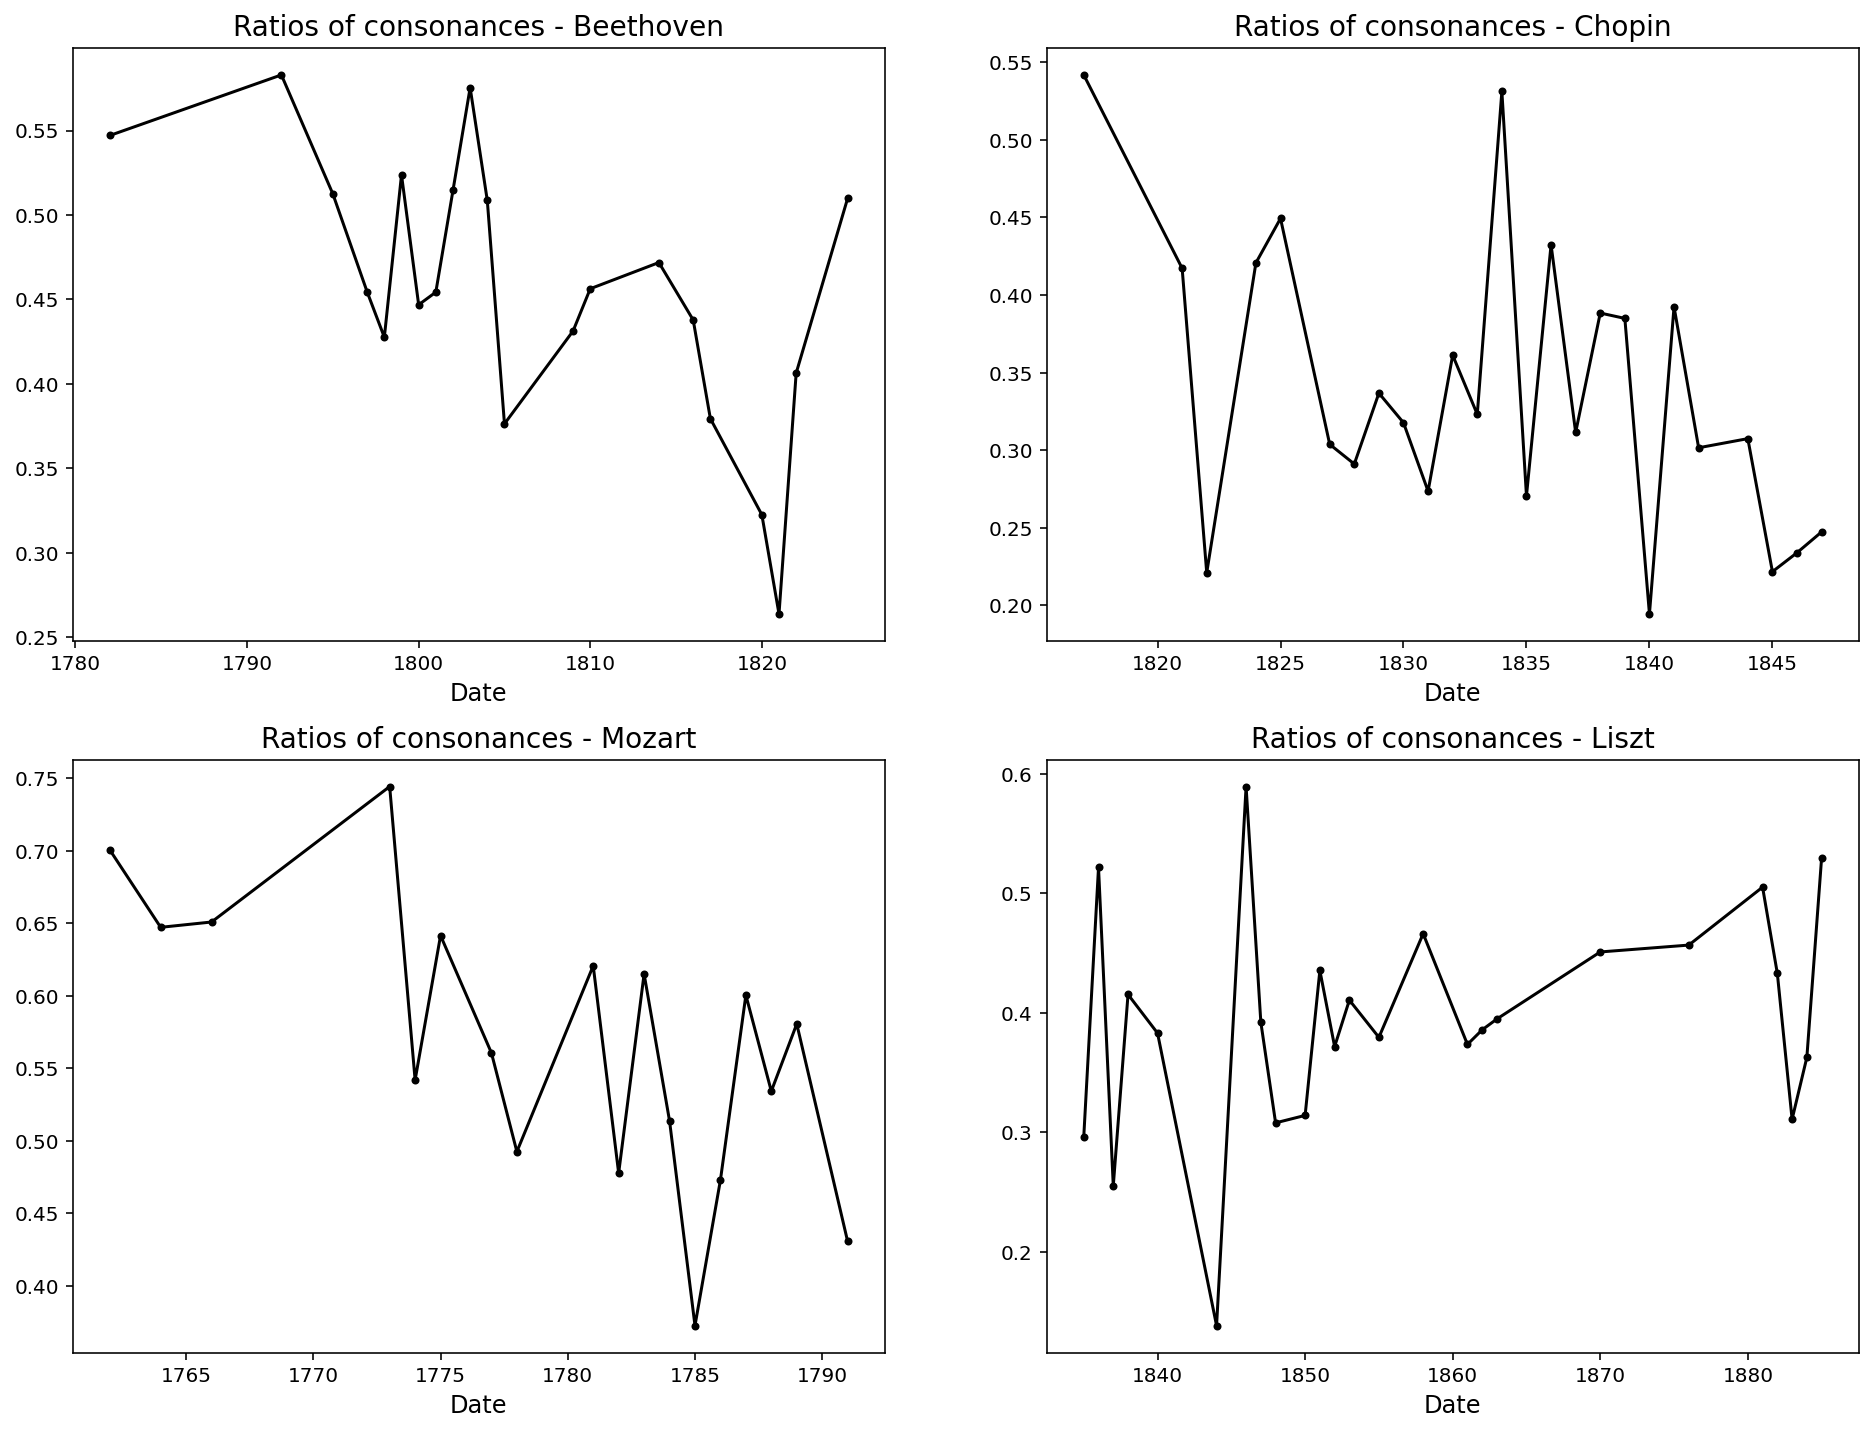

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

axs[0, 0].set_title(f'Ratios of consonances - Beethoven', size=14)
axs[0, 0].set_xlabel('Date', size=12)
axs[0, 0].plot(beethoven_years, beethoven_ratios, marker='.', color='k')

axs[0, 1].set_title(f'Ratios of consonances - Chopin', size=14)
axs[0, 1].set_xlabel('Date', size=12)
axs[0, 1].plot(chopin_years, chopin_ratios, marker='.', color='k')

axs[1, 0].set_title(f'Ratios of consonances - Mozart', size=14)
axs[1, 0].set_xlabel('Date', size=12)
axs[1, 0].plot(mozart_years, mozart_ratios, marker='.', color='k')

axs[1, 1].set_title(f'Ratios of consonances - Liszt', size=14)
axs[1, 1].set_xlabel('Date', size=12)
axs[1, 1].plot(liszt_years, liszt_ratios, marker='.', color='k')

At first glance, each composer has different forms and fluctuates significantly, but we are more concerned with local characteristics.
For the years where works are published, we perform linear regression on each pair of adjacent points, and the slopes of the regression lines obtained are as shown in the figure below.

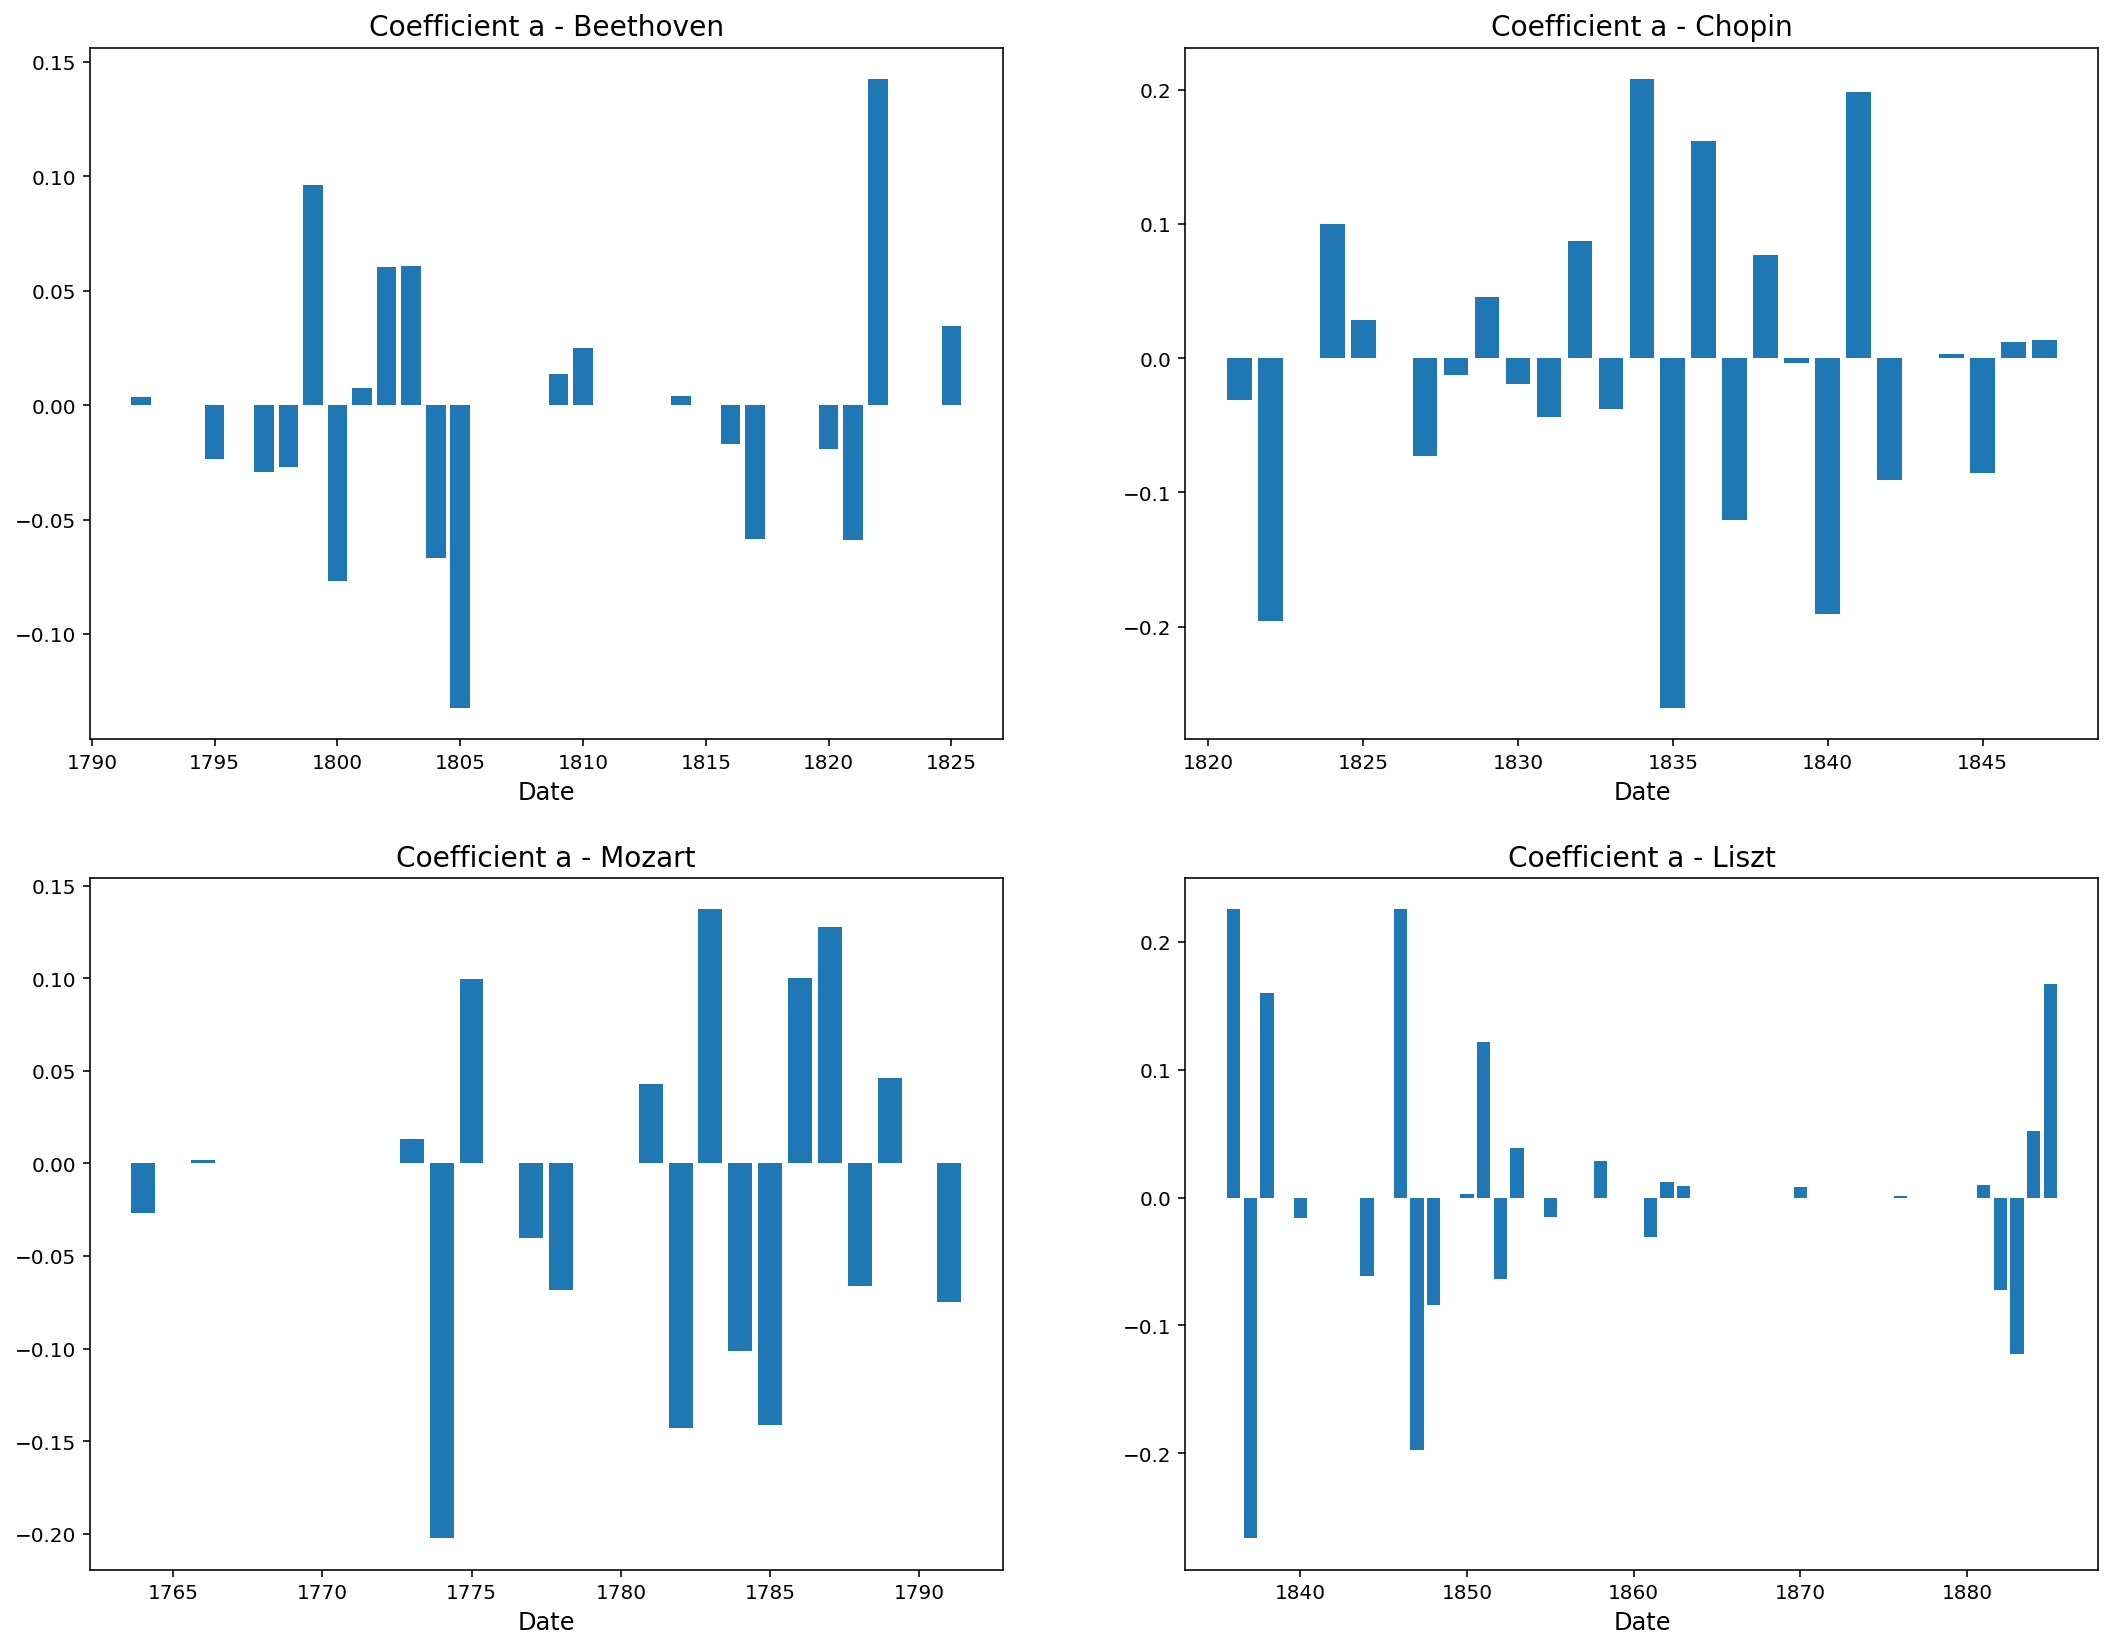

In [46]:
def linear_func(x, a, b):
    return a * x + b

def window_regression(composer_years, composer_ratios, name, p, q):
    window_size = 2
    popt_list = []
    for i in range(0, len(composer_ratios) - window_size + 1):
        popt, _ = curve_fit(linear_func, composer_years[i:i + window_size], composer_ratios[i:i + window_size])
        popt_list.append(popt[0])
    axs[p, q].set_xlabel(f'Date', size=12)
    axs[p, q].set_title(f'Coefficient a - {name}', size=14)
    axs[p, q].bar(composer_years[1:], popt_list, label=name)

fig, axs = plt.subplots(2, 2, figsize=(18, 14))
window_regression(beethoven_years, beethoven_ratios, 'Beethoven', 0, 0)
window_regression(chopin_years, chopin_ratios, 'Chopin', 0, 1)
window_regression(mozart_years, mozart_ratios, 'Mozart', 1, 0)
window_regression(liszt_years, liszt_ratios, 'Liszt', 1, 1)

(Due to the sparse data points in certain periods, we draw a more compact version. Please consider whether we should use the figure above. )

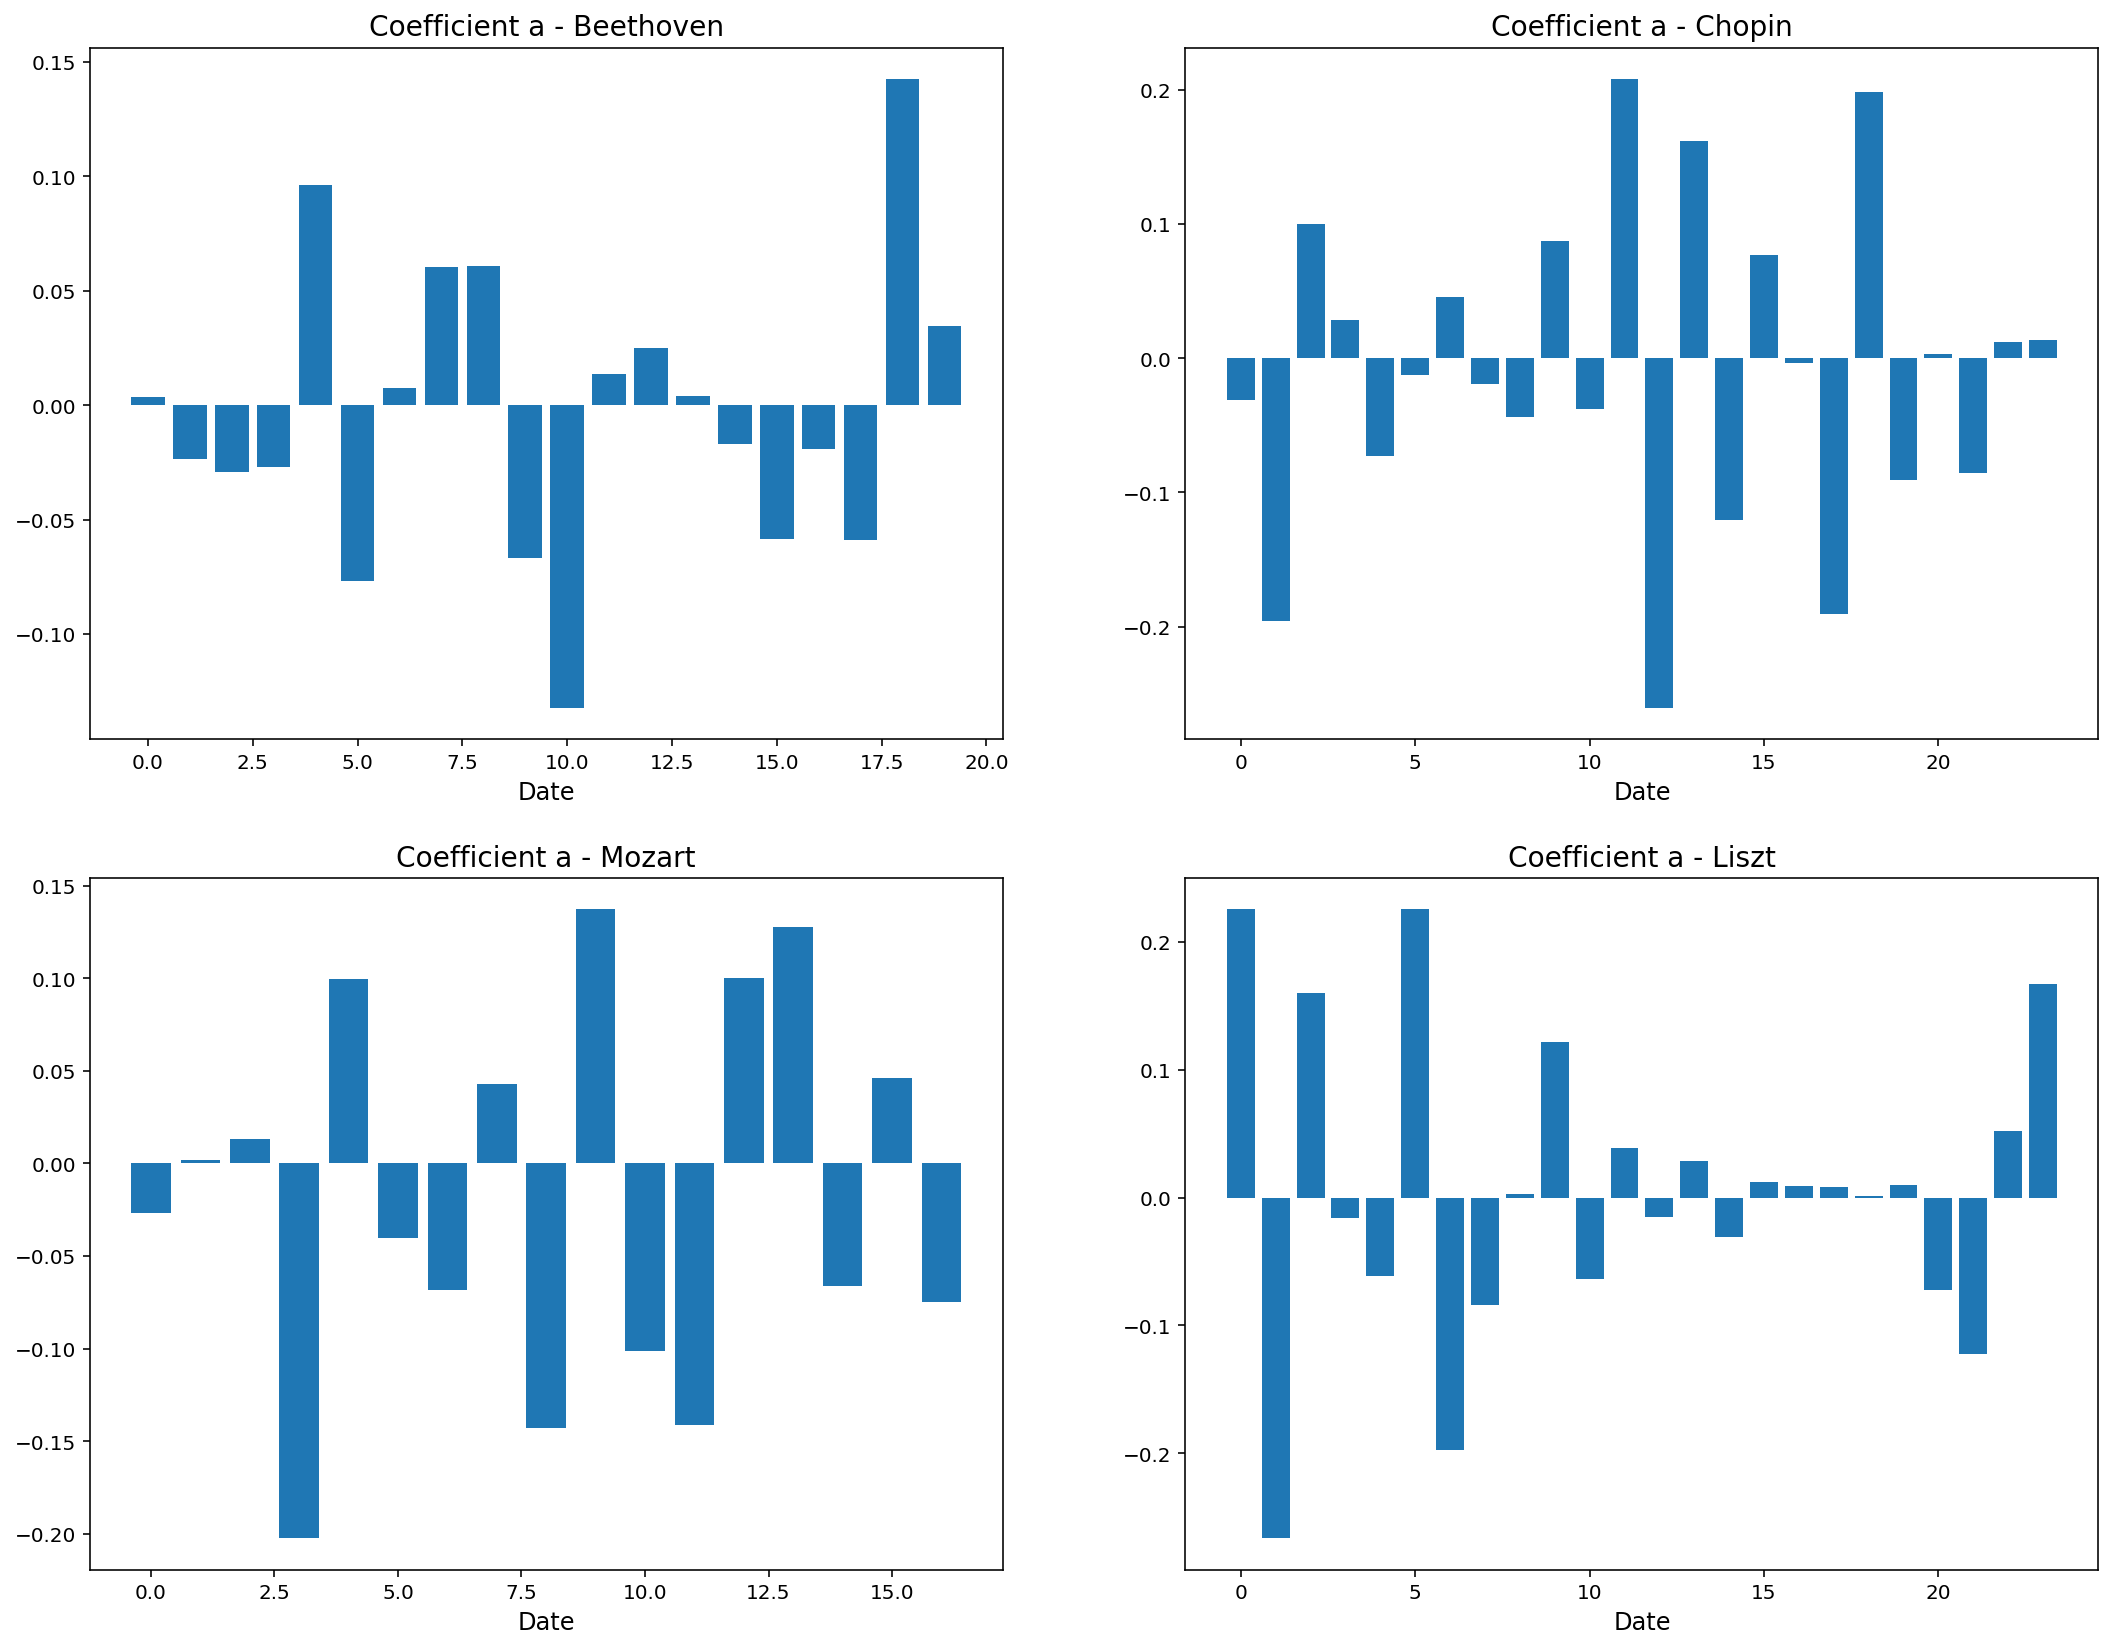

In [47]:
def window_regression(composer_years, composer_ratios, name, p, q):
    window_size = 2
    popt_list = []
    for i in range(0, len(composer_ratios) - window_size + 1):
        popt, _ = curve_fit(linear_func, composer_years[i:i + window_size], composer_ratios[i:i + window_size])
        popt_list.append(popt[0])
    axs[p, q].set_xlabel(f'Date', size=12)
    axs[p, q].set_title(f'Coefficient a - {name}', size=14)
    axs[p, q].bar(range(len(popt_list)), popt_list, label=name)

fig, axs = plt.subplots(2, 2, figsize=(18, 14))
window_regression(beethoven_years, beethoven_ratios, 'Beethoven', 0, 0)
window_regression(chopin_years, chopin_ratios, 'Chopin', 0, 1)
window_regression(mozart_years, mozart_ratios, 'Mozart', 1, 0)
window_regression(liszt_years, liszt_ratios, 'Liszt', 1, 1)

For Chopin, Mozart, and Liszt, the curves of consonance proportions do fluctuate significantly, meaning the use of consonances and dissonances in different years is unconscious. And the regression coefficient of the same sign appears twice consecutively. Although Liszt has five consecutive regression positive coefficients, the values are small and we are more concerned about negative values.  In the late period of Beethoven's career, we can observe four consecutive "large" negative values. This means that he would unconsciously use more and more discordant sounds in his works, which also confirms Czerny's point of view. **(I can only find the statement in Chinese Wikipedia.)** Despite the use of consonances and dissonances in different periods is still unconscious, but because of the gradual loss of hearing, he is using more and more dissonances noticing that. 

To further confirm our conjecture, we mark the period of continuous negative coefficients in the figure below, which happens to be around Beethoven's complete deafness.

In [32]:
### Calculate ratios of consonances by years. 
consonances = []
chords = []
year_list = fluc_df['Published'].unique()
isConsonant = lambda x: music21.chord.Chord(x.split(' ', 1)[1][:-1]).isConsonant()

for year in year_list:
    window_df = fluc_df[fluc_df['Published'] == year]
    total_chords = 0
    total_consonances = 0
    for chord in window_df['Chord']:
        if len(convert_chord(chord)) > 1:
            total_chords += 1
            if isConsonant(chord):
                total_consonances += 1
    chords.append(total_chords)
    consonances.append(total_consonances)

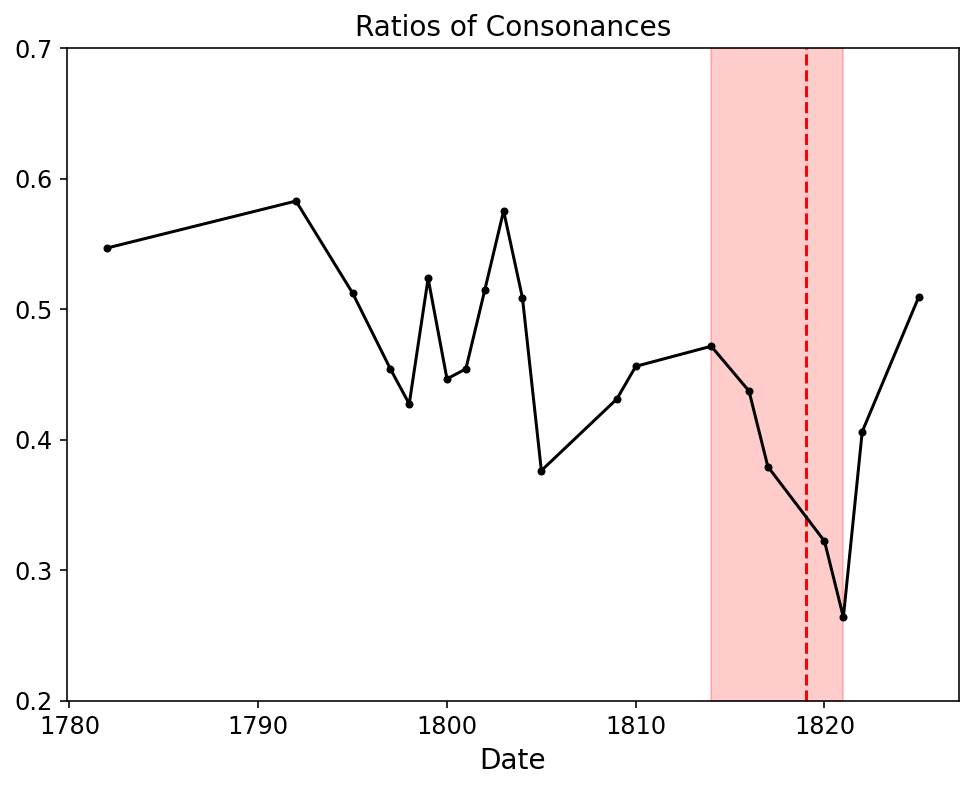

In [33]:
plt.figure(figsize=(8, 6))
y_min, y_max = 0.2, 0.7
plt.fill_betweenx([y_min, y_max], 1814, 1821, color='red', alpha=0.2)
plt.ylim([y_min, y_max])
plt.axvline(1819, color='red', ls='--')
plt.title('Ratios of Consonances', size=14)
plt.xlabel('Date', size=14)
plt.yticks(size=12)
plt.xticks(size=12)
plt.plot(year_list, list(consonances[i]/chords[i] for i in range(len(chords))), marker='.', color='k')

## Conclusions

In the above analysis, we started from the basic attributes of the elements that constitute music and analyzed the potential impact of Beethoven’s ear disease on his composition habits and styles from the perspectives of pitches and chords. 

Although we are unable to obtain direct evidence, we strongly prove the potential impact of ear diseases by utilizing data such as treble and bass trends, the clustering effects of tones, and the proportions of dissonances. We also justify that not all intrinsic properties of compositions are affected, such as the distribution of new chords.

Future work can dig deeper into Beethoven's life experience, and confirm the hypotheses of composition habits in different periods through first-hand letters. It can also analyze the impression of ear diseases on music perception from the views of psychology and medicine experiments. 

## References

Cuthbert, M. S. and Ariza, C. (2010) ‘music21: A Toolkit for Computer-Aided Musicology and Symbolic Music Data’, p. 7.

Holmes, J. A. (2017) ‘Expert Listening beyond the Limits of Hearing: Music and Deafness’, Journal of the American Musicological Society, 70(1), pp. 171–220. doi: 10.1525/jams.2017.70.1.171.

Liu, L. et al. (2013) ‘A Statistical Physics View of Pitch Fluctuations in the Classical Music from Bach to Chopin: Evidence for Scaling’, PLoS ONE. Edited by D. Abbott, 8(3), p. e58710. doi: 10.1371/journal.pone.0058710.

Saccenti, E., Smilde, A. K. and Saris, W. H. M. (2011) ‘Beethoven’s deafness and his three styles’, BMJ, 343(dec20 3), pp. d7589–d7589. doi: 10.1136/bmj.d7589.

White, C. W. and Quinn, I. (2016) ‘The Yale-Classical Archives Corpus’, Empirical Musicology Review, 11(1), p. 50. doi: 10.18061/emr.v11i1.4958.